# Economic Cycles TDA

Introduccion...

## Librerías a usar

Para este proyecto se hará uso de librerías estandar para análisis de datos y Machine Learning, como lo son `numpy`, `scikit-learn`, `pandas` y `matplotlib`, entre otras. Adicionalmente se hará uso de la librería `giotto-tda` para la generacion de complejos y el cálculo de diagramas de persistencia, además de otras tareas propias del Análisis Topológico de Datos.

In [68]:
# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Machine Learning y preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Topological Data Analysis
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import TakensEmbedding
from gtda.time_series import takens_embedding_optimal_parameters

# Auxiliar
import math
import copy
from datetime import datetime

## Datos (Economía Colombiana)

En este análisis se utilizan series temporales macroeconómicas que describen la evolución de la economía colombiana a lo largo del tiempo. La base de datos ha sido construida a partir de diferentes bases oficiales, como lo son el DANE, el Banco de la república, entre otros.

In [12]:
# Importacion de datos
ruta = "../data/base_macro_con_pib.csv"
data = pd.read_csv(ruta)

# Convertir columna de fechas a tipo datetime
data["Fecha"] = pd.to_datetime(data["Fecha"])

print(f"Primera fecha: {data['Fecha'][0]} y última fecha {data['Fecha'][len(data) - 1]}")

# Definirla como índice temporal
data.set_index("Fecha", inplace=True)

data.head()

Primera fecha: 2008-02-01 00:00:00 y última fecha 2025-01-01 00:00:00


,precio_brent_usd,valor_colcap,Indic_de_precios_al_consumidor,Indic_seguimiento_economia,Indic_tasa_de_cambio_real,tasa_desempleo,pib
Fecha,,,,,,,
2008-02-01,100.10,914.90,66.50,75.6,103.65,12.19,151082
2008-03-01,100.30,889.28,67.04,74.3,102.22,11.34,151161
2008-04-01,111.36,985.95,67.51,75.4,99.87,11.08,151246
2008-05-01,127.78,1019.78,68.14,74.6,98.29,10.81,151841
2008-06-01,139.83,945.31,68.73,75.0,94.62,11.41,152455


In [13]:
# Información general del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2008-02-01 to 2025-01-01
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   precio_brent_usd                204 non-null    float64
 1   valor_colcap                    204 non-null    float64
 2   Indic_de_precios_al_consumidor  204 non-null    float64
 3   Indic_seguimiento_economia      204 non-null    float64
 4   Indic_tasa_de_cambio_real       204 non-null    float64
 5   tasa_desempleo                  204 non-null    float64
 6   pib                             204 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 12.8 KB


In [14]:
# Información estadística del DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
precio_brent_usd,204.0,78.530735,24.331209,26.35,59.2500,76.085,101.1150,139.83
valor_colcap,204.0,1407.582108,242.941117,788.73,1248.2700,1391.575,1604.0050,1901.83
Indic_de_precios_al_consumidor,204.0,95.192255,21.711590,66.50,77.6000,92.650,105.4925,146.24
Indic_seguimiento_economia,204.0,99.733333,14.736058,74.20,87.7000,101.200,110.1750,124.60
Indic_tasa_de_cambio_real,204.0,124.594902,21.648171,92.83,101.8975,128.430,139.4875,175.73
tasa_desempleo,204.0,11.045686,2.272996,7.56,9.4975,10.650,11.9600,21.97
pib,204.0,201730.818627,30353.421413,150420.00,177580.5000,204654.000,220642.5000,252690.00


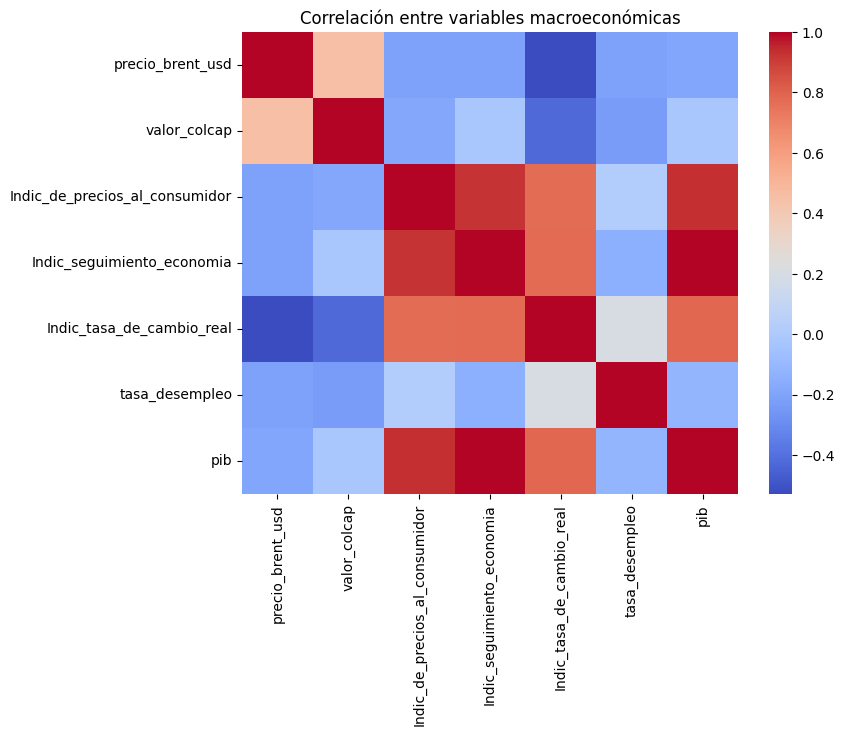

In [15]:
# Tabla de correlaciones
corr = data.corr()
plt.figure(figsize=(8,6)) 
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlación entre variables macroeconómicas")
plt.show()

## Transformación de los datos [Escalamiento]

En esta sección vamos a proceder con una tranformación de escala en los datos, en este caso una normalización.

La Normalización tiene como intención generar un conjunto de datos que mantenga las relaciones entre variables sin importar la escala de estas, mapeando todos los valores del DataFrame a valores entre [0, 1].

In [16]:
# Normalizacion
scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

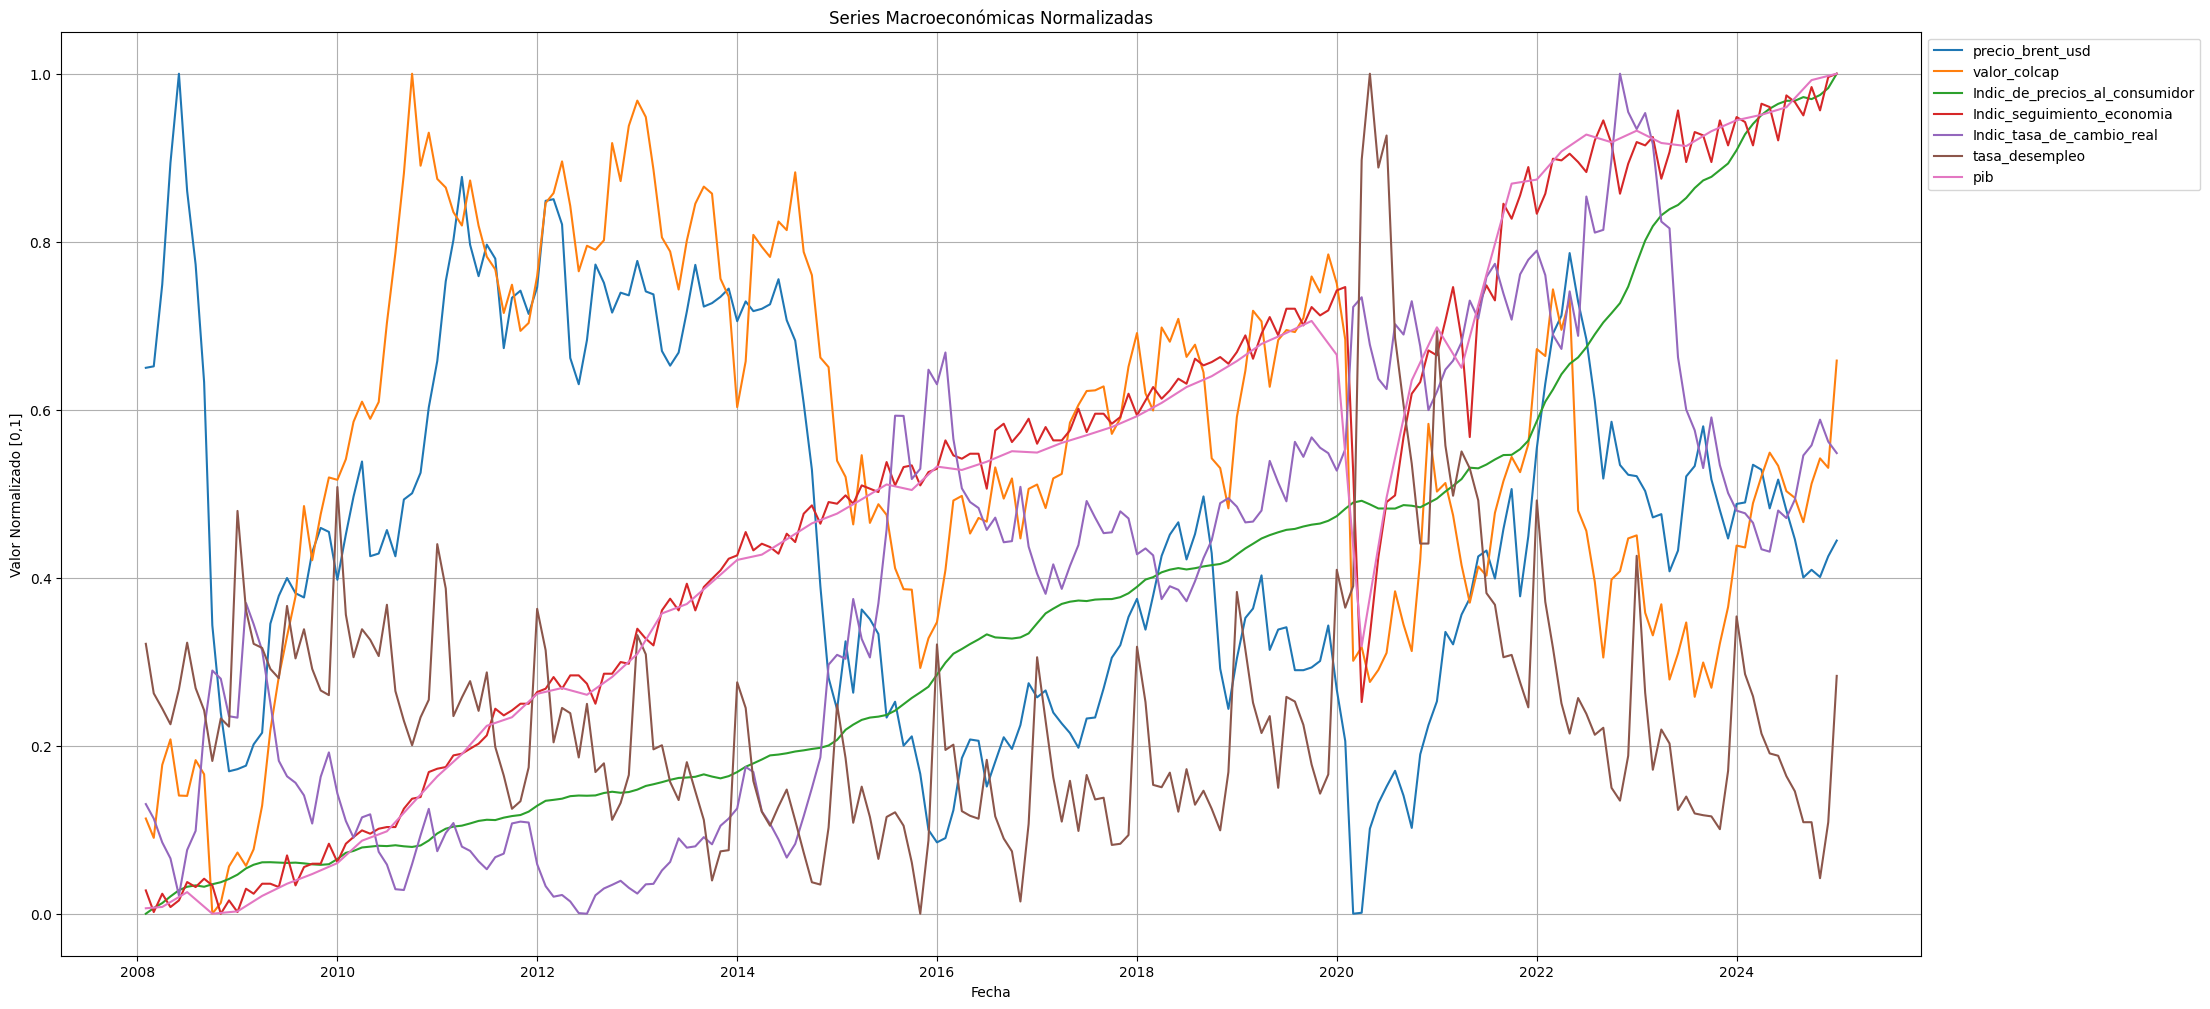

In [17]:
# Gráfica de Datos Normalizados
plt.figure(figsize=(24, 12))

for col in data_norm.columns:
    plt.plot(data_norm.index, data_norm[col], label=col)
plt.title("Series Macroeconómicas Normalizadas")
plt.xlabel("Fecha")
plt.ylabel("Valor Normalizado [0,1]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

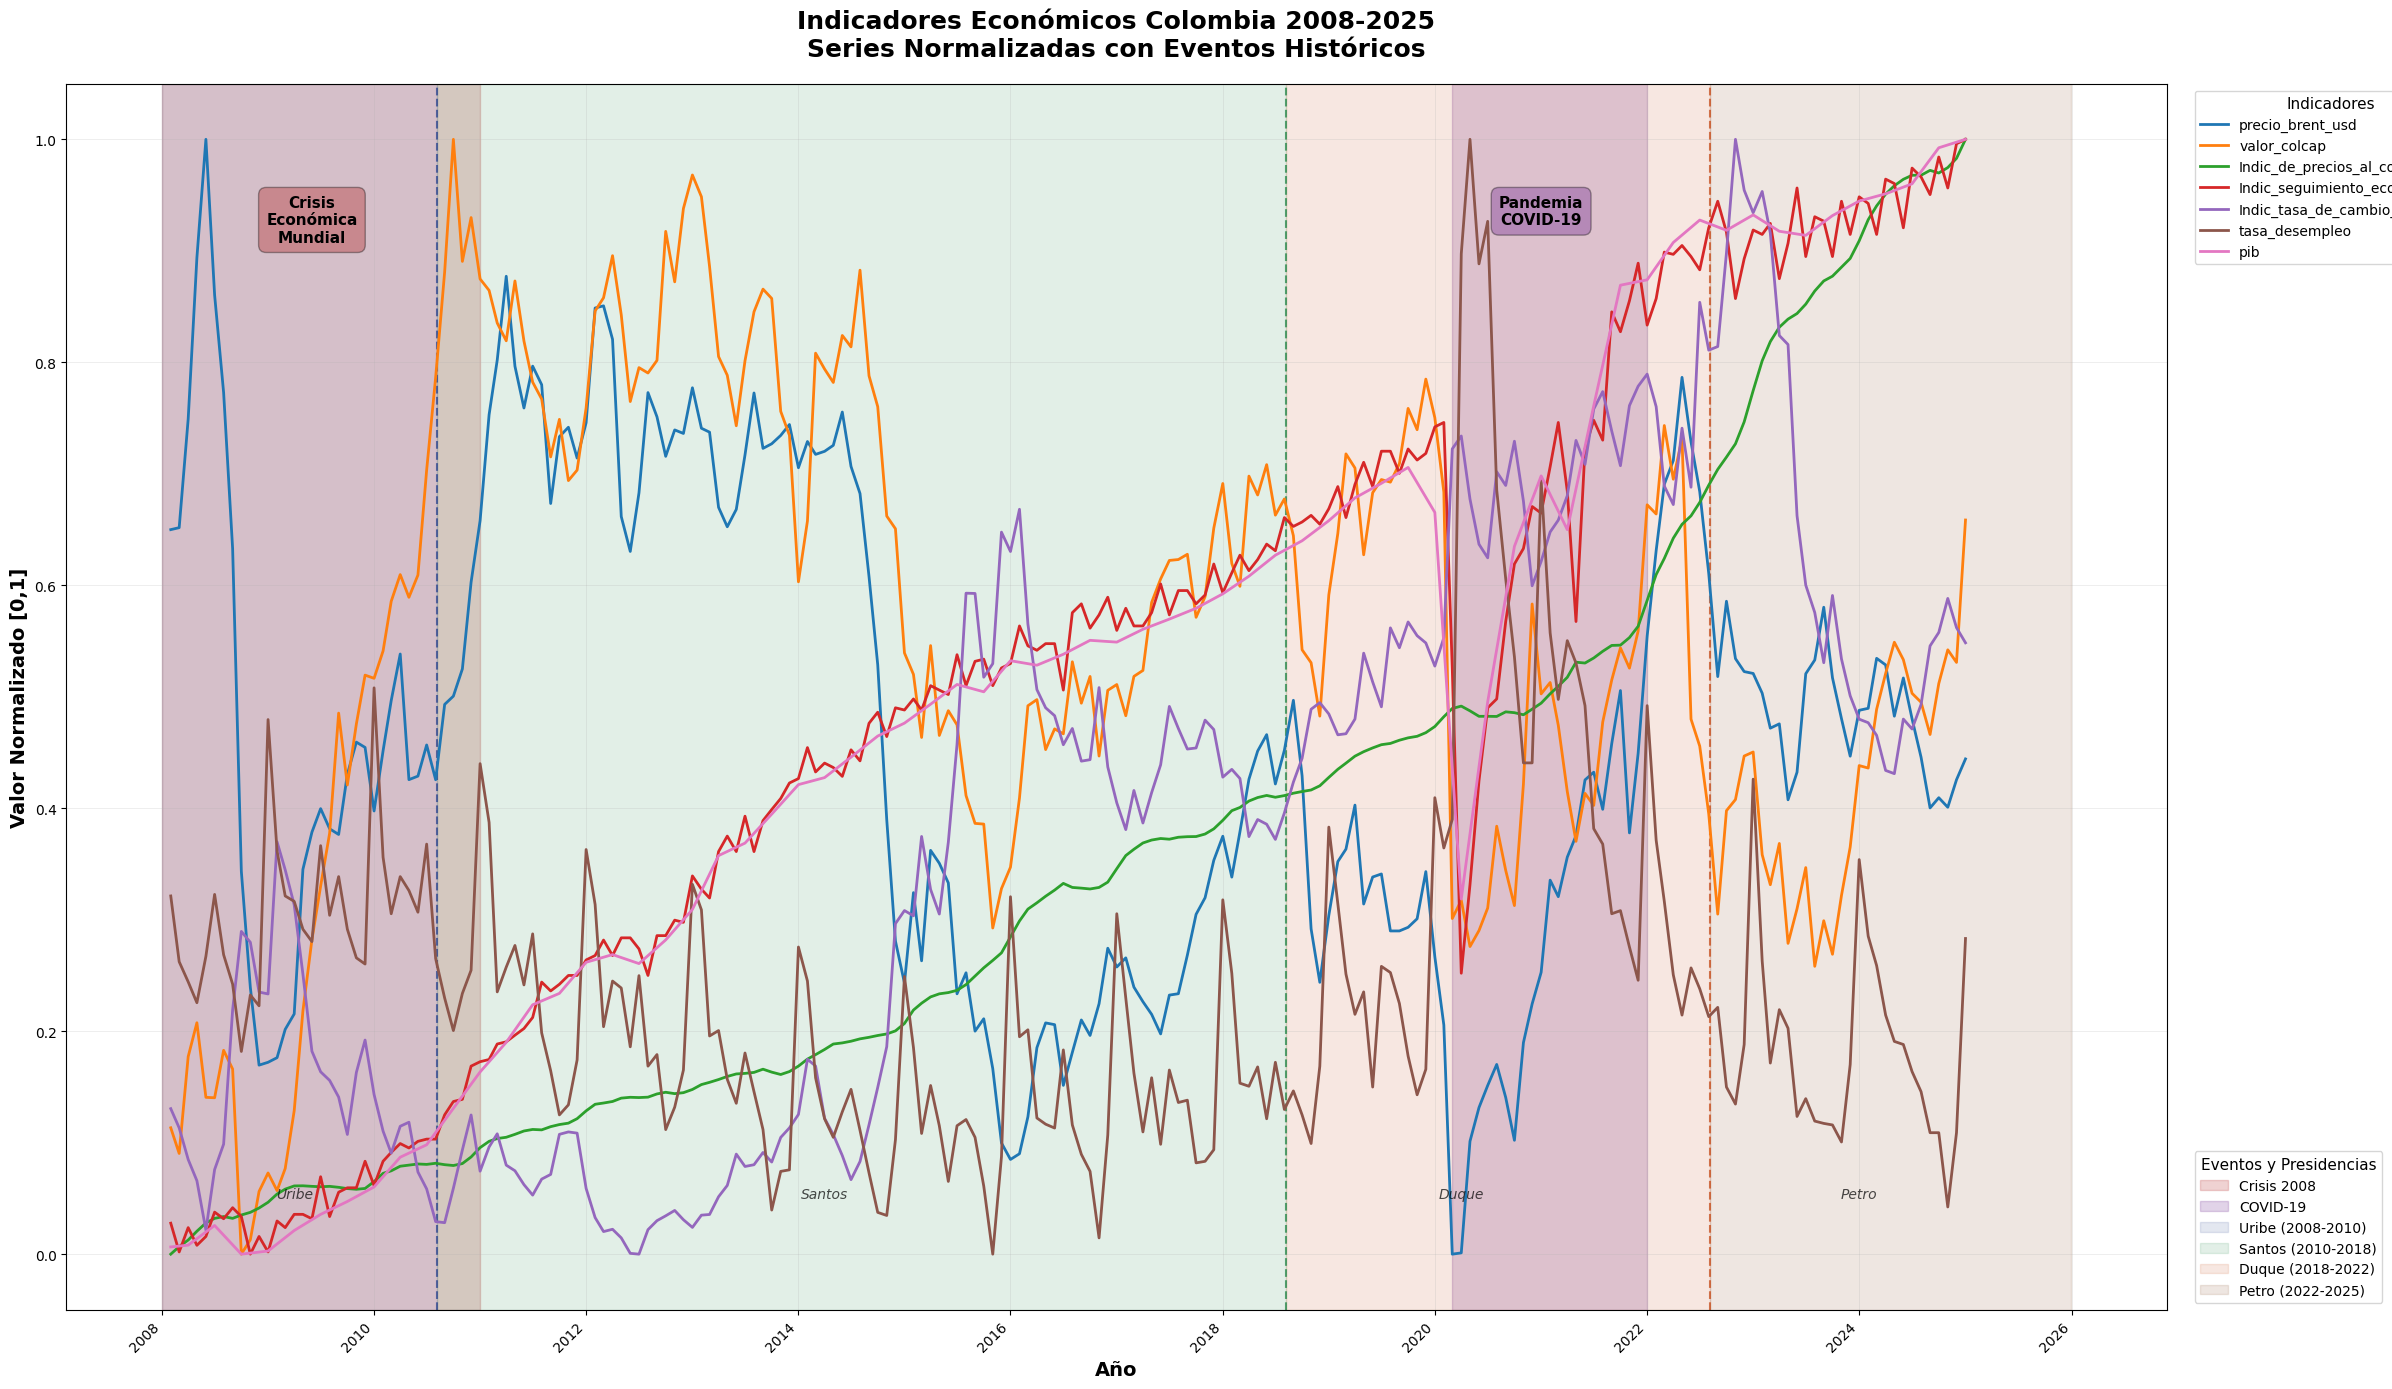

In [18]:
# Configuración de la figura
plt.figure(figsize=(24, 14))
ax = plt.gca()

# === LAPSOS DE EVENTOS ECONÓMICOS ===
# Crisis económica mundial 2008 (impacto y recuperación lenta)
ax.axvspan(datetime(2008, 1, 1), datetime(2010, 12, 31), 
           alpha=0.20, color='#B22222')

# Pandemia COVID-19 (caída y recuperación)
ax.axvspan(datetime(2020, 3, 1), datetime(2021, 12, 31), 
           alpha=0.20, color='#6B238E')

# === PERIODOS PRESIDENCIALES ===
# Álvaro Uribe Vélez (hasta 2010)
ax.axvspan(datetime(2008, 1, 1), datetime(2010, 8, 7), 
           alpha=0.12, color='#1E3A8A')

# Juan Manuel Santos (2010-2018)
ax.axvspan(datetime(2010, 8, 7), datetime(2018, 8, 7), 
           alpha=0.12, color='#15803D')

# Iván Duque (2018-2022)
ax.axvspan(datetime(2018, 8, 7), datetime(2022, 8, 7), 
           alpha=0.12, color='#C2410C')

# Gustavo Petro (2022-2025)
ax.axvspan(datetime(2022, 8, 7), datetime(2025, 12, 31), 
           alpha=0.12, color='#78350F')

# === LÍNEAS DE TRANSICIÓN PRESIDENCIAL ===
ax.axvline(x=datetime(2010, 8, 7), color='#1E3A8A', linestyle='--', 
           linewidth=1.5, alpha=0.7)
ax.axvline(x=datetime(2018, 8, 7), color='#15803D', linestyle='--', 
           linewidth=1.5, alpha=0.7)
ax.axvline(x=datetime(2022, 8, 7), color='#C2410C', linestyle='--', 
           linewidth=1.5, alpha=0.7)

# === GRÁFICA DE SERIES NORMALIZADAS ===
for col in data_norm.columns:
    plt.plot(data_norm.index, data_norm[col], label=col, linewidth=2)

# === ANOTACIONES DE EVENTOS ===
# Crisis 2008
ax.text(datetime(2009, 6, 1), 0.95, 'Crisis\nEconómica\nMundial', 
        fontsize=11, ha='center', va='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#B22222', alpha=0.35),
        fontweight='bold')

# COVID-19
ax.text(datetime(2021, 1, 1), 0.95, 'Pandemia\nCOVID-19', 
        fontsize=11, ha='center', va='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#6B238E', alpha=0.35),
        fontweight='bold')

# Etiquetas presidenciales
ax.text(datetime(2009, 4, 1), 0.05, 'Uribe', 
        fontsize=10, ha='center', style='italic', alpha=0.7)
ax.text(datetime(2014, 4, 1), 0.05, 'Santos', 
        fontsize=10, ha='center', style='italic', alpha=0.7)
ax.text(datetime(2020, 4, 1), 0.05, 'Duque', 
        fontsize=10, ha='center', style='italic', alpha=0.7)
ax.text(datetime(2024, 1, 1), 0.05, 'Petro', 
        fontsize=10, ha='center', style='italic', alpha=0.7)

# === CONFIGURACIÓN DE LA GRÁFICA ===
plt.title("Indicadores Económicos Colombia 2008-2025\nSeries Normalizadas con Eventos Históricos", 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Año", fontsize=14, fontweight='bold')
plt.ylabel("Valor Normalizado [0,1]", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# === LEYENDAS ===
# Leyenda principal (series de datos)
legend1 = plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1), 
                     fontsize=10, title="Indicadores", title_fontsize=11)
ax.add_artist(legend1)

# Leyenda secundaria (eventos y periodos)
# Crear patches personalizados para los eventos
crisis_patch = mpatches.Patch(color='#B22222', alpha=0.20, 
                              label='Crisis 2008')
covid_patch = mpatches.Patch(color='#6B238E', alpha=0.20, 
                             label='COVID-19')
uribe_patch = mpatches.Patch(color='#1E3A8A', alpha=0.12, 
                            label='Uribe (2008-2010)')
santos_patch = mpatches.Patch(color='#15803D', alpha=0.12, 
                             label='Santos (2010-2018)')
duque_patch = mpatches.Patch(color='#C2410C', alpha=0.12, 
                            label='Duque (2018-2022)')
petro_patch = mpatches.Patch(color='#78350F', alpha=0.12, 
                            label='Petro (2022-2025)')

legend2 = plt.legend(handles=[crisis_patch, covid_patch, uribe_patch, 
                             santos_patch, duque_patch, petro_patch],
                    loc="lower left", bbox_to_anchor=(1.01, 0),
                    fontsize=10, title="Eventos y Presidencias", 
                    title_fontsize=11)

# Ajustar límites del eje Y
plt.ylim(-0.05, 1.05)

# Formato de fechas en el eje X
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(2))
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Time Delay Embedding (Single Embedding)

El Time Delay Embedding es una forma estandar muy utilizada en Análisis Topológico de Datos sobre series de tiempo, en la cual se transforma una serie de tiempo $f(t)$ univariada a una nube de puntos en $\mathbb{R}^{d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau}f: \mathbb{R} \to \mathbb{R}^{d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f(t)\\[4pt]
f(t+\tau)\\[4pt]
\vdots\\[4pt]
f\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

In [19]:
# Definición de parámetros (Arbitrarios)
embedding_dimension = 3   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 2  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

### Selección de parámetros

Giotto tiene implementadas internamente funciones que encuentran los parámetros $d$ y $\tau$ óptimos en un rango.

In [20]:
# Definición de parámetros (Optimos)
results = []
for col in data_norm.columns:
    serie = data_norm[col].values
    n = len(serie)
    max_tau = min(30, n // 10)
    max_dim = min(8, n // (2 * max_tau))
    
    tau, dim = takens_embedding_optimal_parameters(
        serie,
        max_time_delay=max_tau,
        max_dimension=max_dim
    )
    results.append((col, tau, dim))

optimal_parameters = pd.DataFrame(results, columns=["Serie", "tau", "d"])
optimal_parameters.set_index("Serie", inplace=True)
print(optimal_parameters)


                                tau  d
Serie                                 
precio_brent_usd                  4  4
valor_colcap                      8  5
Indic_de_precios_al_consumidor   16  4
Indic_seguimiento_economia       13  5
Indic_tasa_de_cambio_real        17  2
tasa_desempleo                    5  5
pib                              19  3


In [21]:
# Single Time Delay Embedding con GTDA
from gtda.time_series import SingleTakensEmbedding

# Función de Embedding TD_d,tau
def embedder_single(tau, d, serie):
    return SingleTakensEmbedding(parameters_type="fixed", n_jobs=-1, time_delay=tau, dimension=d, stride=1).fit_transform(serie)

In [51]:
# Transformación de las series de tiempo
single_embeddings = {}
optimal_parameters_emb = {}

for col in data_norm.columns:
    serie = data_norm[col].values 

    tau = int(optimal_parameters.loc[col, "tau"])
    d = int(optimal_parameters.loc[col, "d"])

    optimal_parameters_emb[col] = (tau, d)
    emb = embedder_single(tau, d, serie)
    single_embeddings[col] = emb

# Verificar dimensiones
for col, emb in single_embeddings.items():
    print(f"{col}: embedding shape = {emb.shape}")

precio_brent_usd: embedding shape = (192, 4)
valor_colcap: embedding shape = (172, 5)
Indic_de_precios_al_consumidor: embedding shape = (156, 4)
Indic_seguimiento_economia: embedding shape = (152, 5)
Indic_tasa_de_cambio_real: embedding shape = (187, 2)
tasa_desempleo: embedding shape = (184, 5)
pib: embedding shape = (166, 3)


In [ ]:
# --- Crear títulos con parámetros antes de make_subplots ---
subplot_titles_list = []
for name in single_embeddings.keys():
    tau = optimal_parameters_emb[name][0]
    d = optimal_parameters_emb[name][1]
    subplot_titles_list.append(f"{name}<br>τ={tau}, d={d}")

# --- Crear la cuadrícula dinámica de subplots ---
n = len(single_embeddings)
cols = math.ceil(math.sqrt(n) + 1)
rows = math.ceil(n / cols)

fig = make_subplots(
    rows=rows,
    cols=cols,
    specs=[[{'type': 'scatter3d'} for _ in range(cols)] for _ in range(rows)],
    subplot_titles=subplot_titles_list
)

# --- Graficar cada embedding ---
for i, (name, arr) in enumerate(single_embeddings.items()):
    # Obtener parámetros óptimos
    tau = optimal_parameters_emb[name][0]
    d = optimal_parameters_emb[name][1]
    
    # Ajustar dimensionalidad para 3D
    n_points, dim = arr.shape

    if dim < 3:
        # Rellenar con ceros hasta tener 3 dimensiones
        arr_3d = np.hstack([arr, np.zeros((n_points, 3 - dim))])
        info_extra = f" (dim={dim}→3D)"
    elif dim > 3:
        # Reducir con PCA
        pca = PCA(n_components=3)
        arr_3d = pca.fit_transform(arr)
        explained = np.sum(pca.explained_variance_ratio_)
        info_extra = f" (PCA: {explained:.1%} var)"
    else:
        arr_3d = arr
        info_extra = ""

    # Posición en la cuadrícula
    r = i // cols + 1
    c = i % cols + 1

    # Obtener fechas correspondientes al embedding
    # El embedding tiene menos puntos que la serie original debido a tau y d
    n_original = len(data)
    start_idx = n_original - len(arr_3d)  # Índice de inicio del embedding
    fechas_embedding = data.index[start_idx:start_idx + len(arr_3d)]
    
    # Convertir fechas a strings para el hover
    fechas_str = [fecha.strftime('%Y-%m-%d') for fecha in fechas_embedding]
    
    # Añadir la nube 3D con gradiente de color por índice temporal
    colors = np.arange(len(arr_3d))  # Color según posición temporal
    
    fig.add_trace(
        go.Scatter3d(
            x=arr_3d[:, 0],
            y=arr_3d[:, 1],
            z=arr_3d[:, 2],
            mode='markers',
            marker=dict(
                size=3, 
                opacity=0.7,
                color=colors,
                colorscale='Viridis',
                showscale=(i == 0),  # Mostrar escala solo en el primero
                colorbar=dict(
                    title="Tiempo",
                    x=1.02,
                    len=0.3
                ) if i == 0 else None
            ),
            name=f"{name}{info_extra}",
            text=fechas_str,
            hovertemplate=f"<b>{name}</b><br>τ={tau}, d={d}<br>" +
                         "<b>Fecha:</b> %{text}<br>" +
                         "x: %{x:.3f}<br>y: %{y:.3f}<br>z: %{z:.3f}<extra></extra>"
        ),
        row=r, col=c
    )

# --- Ajustes estéticos ---
fig.update_layout(
    height=350 * rows,
    width=350 * cols,
    showlegend=False,
    title_text="Embeddings Takens 3D con Parámetros Óptimos (τ, d)",
    title_font_size=16,
    margin=dict(l=0, r=0, t=80, b=0),
)

# Actualizar ejes para mejor visualización
for i in range(1, rows * cols + 1):
    fig.update_scenes(
        dict(
            xaxis=dict(showgrid=True, gridcolor='lightgray', showbackground=True, backgroundcolor='white'),
            yaxis=dict(showgrid=True, gridcolor='lightgray', showbackground=True, backgroundcolor='white'),
            zaxis=dict(showgrid=True, gridcolor='lightgray', showbackground=True, backgroundcolor='white'),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        row=(i-1)//cols + 1,
        col=(i-1)%cols + 1
    )

# Ajustar tamaño de fuente de títulos de subplots
fig.update_annotations(font_size=10)

fig.show()

## Time Delay Embedding (MultiTakens Embedding)

La versión MultiTakens de la transformación Time Delay Embedding es una forma se transforma una serie de tiempo $F(t) = \left[f_1(t), ..., f_m(t) \right]$ multivariada a una nube de puntos en $\mathbb{R}^{m \times d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau, m}f: \mathbb{R} \to \mathbb{R}^{m \times d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f_1(t)\\[4pt]
f_1(t+\tau)\\[4pt]
\vdots\\[4pt]
f_1\bigl(t+(d-1)\tau\bigr)\\[4pt]
f_2(t)\\[4pt]
\vdots\\[4pt]
f_m(t)\\[4pt]
f_m(t+\tau)\\[4pt]
\vdots\\[4pt]
f_m\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

En esta transformación se añaden dos parámetros adicionales:
- `flatten` que puede ser `True` si se busca que el resultado quede en un vector que incluya todas las variables indiscriminadamente, o `False` de lo contrario.
- `ensure_last_value` que puede ser `True` si se busca asegurar que se incluya siempre la última observación, sin importar desalineación de los vectores del embedding.

In [24]:
# Definición de parámetros (Multi)
embedding_dimension = 5   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 11  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

In [25]:
# Multivariate Time Delay Embedding con GTDA
from gtda.time_series import TakensEmbedding

# Función de Embedding TD_d,tau
def embedder_multi(tau, d, serie):
    return TakensEmbedding(time_delay=tau, dimension=d, stride=1, flatten=True, ensure_last_value=True).fit_transform(serie)

In [26]:
# Transformación del DataFrame (Matriz Single Embeddings)
print("Embedding MultiTakens 3D (Matriz de Single Embeddings):")
X = data_norm.values
print(f"shape de los datos originales: {X.shape}")

# Dimensiones de la tabla original
n_rows, n_series = X.shape

X_emb = embedder_multi(embedding_time_delay, embedding_dimension, X.T)
print(f"Shape del Embedding: {X_emb.shape}")

Embedding MultiTakens 3D (Matriz de Single Embeddings):
shape de los datos originales: (204, 7)
Shape del Embedding: (7, 160, 5)


In [ ]:
# Reducir de 7D a 3D original
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # (198, 3)

# Obtener varianza explicada
var_exp = pca.explained_variance_ratio_
var_total = np.sum(var_exp)

# Obtener fechas correspondientes
# Asumiendo que X tiene las mismas fechas que data.index (ajustar si es necesario)
fechas_X = data.index[:len(X_pca)]
fechas_str = [fecha.strftime('%Y-%m-%d') for fecha in fechas_X]

# Crear gradiente de color temporal
colors = np.arange(len(X_pca))

# Graficar
fig = go.Figure()

# Traza de línea (trayectoria)
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='lines',
    line=dict(
        width=3,
        color=colors,
        colorscale='Viridis',
        showscale=False
    ),
    name="Trayectoria",
    hoverinfo='skip',
    showlegend=True
))

# Traza de marcadores (puntos con hover)
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=colors,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            title="Tiempo",
            tickvals=[0, len(colors)//2, len(colors)-1],
            ticktext=[fechas_str[0], fechas_str[len(colors)//2], fechas_str[-1]],
            len=0.5,
            thickness=15
        ),
        line=dict(width=0.5, color='white')
    ),
    text=fechas_str,
    name="Datos",
    hovertemplate="<b>Fecha:</b> %{text}<br>" +
                  f"<b>PC1</b> ({var_exp[0]:.1%}): %{{x:.3f}}<br>" +
                  f"<b>PC2</b> ({var_exp[1]:.1%}): %{{y:.3f}}<br>" +
                  f"<b>PC3</b> ({var_exp[2]:.1%}): %{{z:.3f}}<br>" +
                  "<extra></extra>",
    showlegend=True
))

# Marcar inicio y fin
fig.add_trace(go.Scatter3d(
    x=[X_pca[0, 0]],
    y=[X_pca[0, 1]],
    z=[X_pca[0, 2]],
    mode='markers',
    marker=dict(size=10, color='green', symbol='diamond', line=dict(width=2, color='white')),
    name=f"Inicio ({fechas_str[0]})",
    hovertemplate=f"<b>Inicio</b><br>Fecha: {fechas_str[0]}<extra></extra>"
))

fig.add_trace(go.Scatter3d(
    x=[X_pca[-1, 0]],
    y=[X_pca[-1, 1]],
    z=[X_pca[-1, 2]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='diamond', line=dict(width=2, color='white')),
    name=f"Fin ({fechas_str[-1]})",
    hovertemplate=f"<b>Fin</b><br>Fecha: {fechas_str[-1]}<extra></extra>"
))

fig.update_layout(
    title=dict(
        text=f"Proyección PCA 3D de Datos Normalizados Originales<br>" +
             f"<sub>Varianza explicada total: {var_total:.1%} " +
             f"(PC1: {var_exp[0]:.1%}, PC2: {var_exp[1]:.1%}, PC3: {var_exp[2]:.1%})</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    scene=dict(
        xaxis=dict(
            title=f"PC1 ({var_exp[0]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='white'
        ),
        yaxis=dict(
            title=f"PC2 ({var_exp[1]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='white'
        ),
        zaxis=dict(
            title=f"PC3 ({var_exp[2]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='white'
        ),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    height=700,
    width=900,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=100, b=0)
)

fig.show()

# Imprimir información adicional
print(f"\n{'='*60}")
print(f"INFORMACIÓN DEL ANÁLISIS PCA")
print(f"{'='*60}")
print(f"Dimensión original: {X.shape[1]}D")
print(f"Dimensión reducida: 3D")
print(f"Número de observaciones: {len(X_pca)}")
print(f"\nVarianza explicada por componente:")
for i, var in enumerate(var_exp, 1):
    print(f"  PC{i}: {var:.2%}")
print(f"\nVarianza total explicada: {var_total:.2%}")
print(f"Período: {fechas_str[0]} a {fechas_str[-1]}")
print(f"{'='*60}\n")


INFORMACIÓN DEL ANÁLISIS PCA
Dimensión original: 7D
Dimensión reducida: 3D
Número de observaciones: 204

Varianza explicada por componente:
  PC1: 67.38%
  PC2: 18.33%
  PC3: 6.14%

Varianza total explicada: 91.85%
Período: 2008-02-01 a 2025-01-01



In [48]:
# Transformación del DataFrame (Concatenación)
print("Embedding MultiTakens 2D (Concatenación):")

n_series, n_windows, n_features = X_emb.shape
print(f"Shape original (3D): {X_emb.shape}")

# --- Concatenar todas las series en un solo vector por ventana ---
X_emb_concat = (
    X_emb                       # (n_series, n_windows, n_features)
    .transpose(1, 0, 2)         # → (n_windows, n_series, n_features)
    .reshape(n_windows, -1)     # → (n_windows, n_series * n_features)
)

print(f"Shape concatenado: {X_emb_concat.shape}")

Embedding MultiTakens 2D (Concatenación):
Shape original (3D): (7, 160, 5)
Shape concatenado: (160, 35)


In [ ]:
# Reducir de 21D a 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_emb_concat)  # (198, 3)

# Obtener varianza explicada
var_exp = pca.explained_variance_ratio_
var_total = np.sum(var_exp)

# Obtener fechas correspondientes al embedding concatenado
# El embedding concatenado tiene menos puntos debido a los parámetros tau y d
n_original = len(data)
start_idx = n_original - len(X_pca)
fechas_emb = data.index[start_idx:start_idx + len(X_pca)]
fechas_str = [fecha.strftime('%Y-%m-%d') for fecha in fechas_emb]

# Crear gradiente de color temporal
colors = np.arange(len(X_pca))

# Graficar
fig = go.Figure()

# Traza de línea (trayectoria)
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='lines',
    line=dict(
        width=3,
        color=colors,
        colorscale='Plasma',  # Diferente colorscale para distinguir del anterior
        showscale=False
    ),
    name="Trayectoria",
    hoverinfo='skip',
    showlegend=True
))

# Traza de marcadores (puntos con hover)
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=colors,
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(
            title="Tiempo",
            tickvals=[0, len(colors)//2, len(colors)-1],
            ticktext=[fechas_str[0], fechas_str[len(colors)//2], fechas_str[-1]],
            len=0.5,
            thickness=15
        ),
        line=dict(width=0.5, color='white')
    ),
    text=fechas_str,
    name="Datos",
    hovertemplate="<b>Fecha:</b> %{text}<br>" +
                  f"<b>PC1</b> ({var_exp[0]:.1%}): %{{x:.3f}}<br>" +
                  f"<b>PC2</b> ({var_exp[1]:.1%}): %{{y:.3f}}<br>" +
                  f"<b>PC3</b> ({var_exp[2]:.1%}): %{{z:.3f}}<br>" +
                  "<extra></extra>",
    showlegend=True
))

# Marcar inicio y fin
fig.add_trace(go.Scatter3d(
    x=[X_pca[0, 0]],
    y=[X_pca[0, 1]],
    z=[X_pca[0, 2]],
    mode='markers',
    marker=dict(size=10, color='lime', symbol='diamond', line=dict(width=2, color='darkgreen')),
    name=f"Inicio ({fechas_str[0]})",
    hovertemplate=f"<b>Inicio</b><br>Fecha: {fechas_str[0]}<extra></extra>"
))

fig.add_trace(go.Scatter3d(
    x=[X_pca[-1, 0]],
    y=[X_pca[-1, 1]],
    z=[X_pca[-1, 2]],
    mode='markers',
    marker=dict(size=10, color='crimson', symbol='diamond', line=dict(width=2, color='darkred')),
    name=f"Fin ({fechas_str[-1]})",
    hovertemplate=f"<b>Fin</b><br>Fecha: {fechas_str[-1]}<extra></extra>"
))

# Calcular información sobre el embedding concatenado
dim_original = X_emb_concat.shape[1]
n_variables = len(single_embeddings)
promedio_dim_por_var = dim_original / n_variables

fig.update_layout(
    title=dict(
        text=f"Proyección PCA 3D del Embedding Concatenado ({n_variables} variables)<br>" +
             f"<sub>Dim original: {dim_original}D → 3D | " +
             f"Varianza explicada: {var_total:.1%} " +
             f"(PC1: {var_exp[0]:.1%}, PC2: {var_exp[1]:.1%}, PC3: {var_exp[2]:.1%})</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    scene=dict(
        xaxis=dict(
            title=f"PC1 ({var_exp[0]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='#f8f8f8'
        ),
        yaxis=dict(
            title=f"PC2 ({var_exp[1]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='#f8f8f8'
        ),
        zaxis=dict(
            title=f"PC3 ({var_exp[2]:.1%})",
            showgrid=True,
            gridcolor='lightgray',
            showbackground=True,
            backgroundcolor='#f8f8f8'
        ),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    height=700,
    width=900,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=100, b=0)
)

fig.show()

# Imprimir información detallada
print(f"\n{'='*60}")
print(f"INFORMACIÓN DEL EMBEDDING CONCATENADO + PCA")
print(f"{'='*60}")
print(f"Número de variables concatenadas: {n_variables}")
print(f"Dimensión del embedding concatenado: {dim_original}D")
print(f"Dimensión promedio por variable: {promedio_dim_por_var:.1f}D")
print(f"Dimensión tras PCA: 3D")
print(f"Número de observaciones: {len(X_pca)}")
print(f"\nVarianza explicada por componente:")
for i, var in enumerate(var_exp, 1):
    print(f"  PC{i}: {var:.2%}")
print(f"\nVarianza total explicada: {var_total:.2%}")
print(f"Varianza no explicada: {1-var_total:.2%}")
print(f"\nPeríodo: {fechas_str[0]} a {fechas_str[-1]}")
print(f"Puntos perdidos por embedding: {n_original - len(X_pca)}")
print(f"{'='*60}\n")

# Información adicional sobre las componentes principales
print(f"COMPONENTES PRINCIPALES - Información adicional:")
print(f"{'-'*60}")
loadings = pca.components_
for i in range(3):
    top_features = np.argsort(np.abs(loadings[i]))[-5:][::-1]
    print(f"PC{i+1}: Top 5 dimensiones con mayor peso:")
    for j, feat_idx in enumerate(top_features, 1):
        print(f"  {j}. Dim {feat_idx}: {loadings[i][feat_idx]:.4f}")
print(f"{'='*60}\n")


INFORMACIÓN DEL EMBEDDING CONCATENADO + PCA
Número de variables concatenadas: 7
Dimensión del embedding concatenado: 35D
Dimensión promedio por variable: 5.0D
Dimensión tras PCA: 3D
Número de observaciones: 160

Varianza explicada por componente:
  PC1: 61.53%
  PC2: 11.61%
  PC3: 7.19%

Varianza total explicada: 80.33%
Varianza no explicada: 19.67%

Período: 2011-10-01 a 2025-01-01
Puntos perdidos por embedding: 44

COMPONENTES PRINCIPALES - Información adicional:
------------------------------------------------------------
PC1: Top 5 dimensiones con mayor peso:
  1. Dim 22: 0.2611
  2. Dim 23: 0.2460
  3. Dim 14: 0.2427
  4. Dim 15: 0.2181
  5. Dim 31: 0.2173
PC2: Top 5 dimensiones con mayor peso:
  1. Dim 5: 0.4403
  2. Dim 4: -0.3487
  3. Dim 3: -0.3293
  4. Dim 0: 0.2978
  5. Dim 6: 0.2705
PC3: Top 5 dimensiones con mayor peso:
  1. Dim 2: 0.4895
  2. Dim 1: 0.4014
  3. Dim 25: 0.3388
  4. Dim 6: 0.2611
  5. Dim 3: 0.2588



## Complejo de Vietori-Rips y Persistencia

Como funciona el tema de los complejos Vietori-Rips y la persistencia en Giotto...

https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html

In [30]:
# Construcción de la filtración sobre el Complejo
from gtda.homology import VietorisRipsPersistence

# 0: componentes, 1: ciclos, 2: cavidades
homology_dimensions = [0, 1, 2]  

VR = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions,
    n_jobs=-1 
)

In [73]:
# Diagrama de persistencia de los datos iniciales sin transformación
X_3d = X[np.newaxis, :, :]   # shape = (1, 204, 7)

diagram_X = VR.fit_transform(X_3d)

# Extraer el único diagrama (ya que X_3d tiene shape (1, 204, 7))
diagram = diagram_X[0]

# Crear figura
fig = go.Figure()

# Filtrar puntos infinitos
diagram_filtered = diagram[diagram[:, 1] != np.inf]

if len(diagram_filtered) > 0:
    # Obtener rango para la diagonal
    all_points = diagram_filtered[:, :2].flatten()
    min_val = np.min(all_points)
    max_val = np.max(all_points)
    margin = (max_val - min_val) * 0.05
    
    # Agregar línea diagonal (nacimiento = muerte)
    fig.add_trace(
        go.Scatter(
            x=[min_val - margin, max_val + margin],
            y=[min_val - margin, max_val + margin],
            mode='lines',
            line=dict(color='gray', width=2, dash='dash'),
            showlegend=False,
            hoverinfo='skip',
            name='Diagonal'
        )
    )
    
    # Colores más intensos para diferentes dimensiones
    colors_intense = {
        0: 'rgb(0, 76, 153)',      # Azul más intenso
        1: 'rgb(230, 97, 0)',      # Naranja más intenso
        2: 'rgb(28, 117, 28)',     # Verde más intenso
    }
    
    # Graficar puntos por dimensión homológica
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        
        birth = dim_diagram[:, 0]
        death = dim_diagram[:, 1]
        persistence = death - birth
        
        # Normalizar persistencia para tamaño de marcador
        if len(persistence) > 1:
            pers_norm = (persistence - persistence.min()) / (persistence.max() - persistence.min() + 1e-10)
            marker_sizes = 8 + pers_norm * 6  # Tamaño entre 8 y 14
        else:
            marker_sizes = 11
        
        # Opacidad basada en persistencia
        if len(persistence) > 1:
            dist_norm = (persistence - persistence.min()) / (persistence.max() - persistence.min() + 1e-10)
            opacity_values = 0.65 + dist_norm * 0.35  # Opacidad entre 0.65 y 1.0
        else:
            opacity_values = 0.85
        
        # Nombre de la dimensión
        dim_names = {0: 'H₀ (Componentes Conexas)', 1: 'H₁ (Loops/Ciclos)', 2: 'H₂ (Cavidades)'}
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        fig.add_trace(
            go.Scatter(
                x=birth,
                y=death,
                mode='markers',
                marker=dict(
                    size=marker_sizes,
                    color=colors_intense.get(int(dim), 'gray'),
                    opacity=opacity_values if isinstance(opacity_values, float) else opacity_values.tolist(),
                    line=dict(width=1.5, color='white'),
                    symbol='circle'
                ),
                name=dim_name,
                hovertemplate=f"<b>{dim_name}</b><br>" +
                             "Nacimiento: %{x:.4f}<br>" +
                             "Muerte: %{y:.4f}<br>" +
                             "Persistencia: %{customdata:.4f}<br>" +
                             "<extra></extra>",
                customdata=persistence
            )
        )
    
    # Estadísticas para el título
    total_features = len(diagram_filtered)
    max_persistence = np.max(diagram_filtered[:, 1] - diagram_filtered[:, 0])
    
else:
    total_features = 0
    max_persistence = 0

# Layout
fig.update_layout(
    title=dict(
        text=f"Diagrama de Persistencia - Datos Originales (7D)<br>" +
             f"<sub>Complejo Vietoris-Rips | {total_features} características topológicas | " +
             f"Persistencia máx: {max_persistence:.4f}</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title="Nacimiento",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        zeroline=False
    ),
    yaxis=dict(
        title="Muerte",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        zeroline=False
    ),
    plot_bgcolor='white',
    height=700,
    width=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.95)',
        bordercolor='black',
        borderwidth=2,
        font=dict(size=12)
    ),
    margin=dict(l=80, r=40, t=120, b=80),
    hovermode='closest'
)

fig.show()

# --- Resumen estadístico detallado ---
print(f"\n{'='*70}")
print(f"ANÁLISIS DE HOMOLOGÍA PERSISTENTE - DATOS ORIGINALES")
print(f"{'='*70}")
print(f"Dimensión del espacio: {X.shape[1]}D")
print(f"Número de puntos: {X.shape[0]}")
print(f"Total de características topológicas: {total_features}")

if len(diagram_filtered) > 0:
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    print(f"\nDistribución por dimensión homológica:")
    print(f"{'-'*70}")
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        persistence = dim_diagram[:, 1] - dim_diagram[:, 0]
        
        dim_names = {
            0: 'H₀ (Componentes Conexas)',
            1: 'H₁ (Loops/Ciclos)', 
            2: 'H₂ (Cavidades)'
        }
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        print(f"\n{dim_name}:")
        print(f"  Número de características: {len(persistence)}")
        print(f"  Persistencia promedio: {np.mean(persistence):.4f}")
        print(f"  Persistencia mediana: {np.median(persistence):.4f}")
        print(f"  Persistencia máxima: {np.max(persistence):.4f}")
        print(f"  Persistencia mínima: {np.min(persistence):.4f}")
        print(f"  Desviación estándar: {np.std(persistence):.4f}")
        
        # Top 3 características más persistentes
        top_indices = np.argsort(persistence)[-3:][::-1]
        print(f"  Top 3 más persistentes:")
        for idx in top_indices:
            print(f"    - Nacimiento: {dim_diagram[idx, 0]:.4f}, " +
                  f"Muerte: {dim_diagram[idx, 1]:.4f}, " +
                  f"Persistencia: {persistence[idx]:.4f}")

print(f"\n{'='*70}")
print(f"INTERPRETACIÓN:")
print(f"{'-'*70}")
print("• Puntos alejados de la diagonal = características persistentes/importantes")
print("• H₀: Número de componentes conexas (clusters en los datos)")
print("• H₁: Ciclos o loops en la estructura (periodicidades, oscilaciones)")
print("• H₂: Cavidades 2D (estructuras huecas en el espacio de fase)")
print("• Características persistentes revelan la topología del atractor subyacente")
print(f"{'='*70}\n")

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




ANÁLISIS DE HOMOLOGÍA PERSISTENTE - DATOS ORIGINALES
Dimensión del espacio: 7D
Número de puntos: 204
Total de características topológicas: 235

Distribución por dimensión homológica:
----------------------------------------------------------------------

H₀ (Componentes Conexas):
  Número de características: 203
  Persistencia promedio: 0.1014
  Persistencia mediana: 0.0910
  Persistencia máxima: 0.2871
  Persistencia mínima: 0.0213
  Desviación estándar: 0.0459
  Top 3 más persistentes:
    - Nacimiento: 0.0000, Muerte: 0.2871, Persistencia: 0.2871
    - Nacimiento: 0.0000, Muerte: 0.2716, Persistencia: 0.2716
    - Nacimiento: 0.0000, Muerte: 0.2683, Persistencia: 0.2683

H₁ (Loops/Ciclos):
  Número de características: 31
  Persistencia promedio: 0.0118
  Persistencia mediana: 0.0072
  Persistencia máxima: 0.0713
  Persistencia mínima: 0.0007
  Desviación estándar: 0.0140
  Top 3 más persistentes:
    - Nacimiento: 0.2826, Muerte: 0.3539, Persistencia: 0.0713
    - Nacimiento: 0.144

In [79]:
# Diagrama de persistencia de cada serie 
diagram_emb = VR.fit_transform(X_emb)

# --- Crear la cuadrícula dinámica de subplots ---
n = len(data_norm.columns)
cols = min(4, n)  # Máximo 3 columnas para mejor visualización
rows = math.ceil(n / cols)

# Preparar títulos con información de parámetros
subplot_titles_list = []
for name in data_norm.columns:
    if name in optimal_parameters_emb:
        tau = optimal_parameters_emb[name][0]
        d = optimal_parameters_emb[name][1]
        subplot_titles_list.append(f"<b>{name}</b><br><span style='font-size:11px'>τ={tau}, d={d}</span>")
    else:
        subplot_titles_list.append(f"<b>{name}</b>")

fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=subplot_titles_list,
    vertical_spacing=0.15,
    horizontal_spacing=0.10
)

# Colores para diferentes dimensiones homológicas
colors_dim = {
    0: 'rgb(31, 119, 180)',   # Azul para H0 (componentes conexas)
    1: 'rgb(255, 127, 14)',   # Naranja para H1 (loops)
    2: 'rgb(44, 160, 44)',    # Verde para H2 (cavidades)
}

# --- Graficar cada diagrama de persistencia ---
for i, (name, diagram) in enumerate(zip(data_norm.columns, diagram_emb)):
    r = i // cols + 1
    c = i % cols + 1
    
    # Filtrar puntos infinitos y separar por dimensión
    diagram_filtered = diagram[diagram[:, 1] != np.inf]
    
    if len(diagram_filtered) == 0:
        continue
    
    # Obtener rango para la diagonal
    all_points = diagram_filtered[:, :2].flatten()
    min_val = np.min(all_points)
    max_val = np.max(all_points)
    margin = (max_val - min_val) * 0.05
    
    # Agregar línea diagonal (nacimiento = muerte)
    fig.add_trace(
        go.Scatter(
            x=[min_val - margin, max_val + margin],
            y=[min_val - margin, max_val + margin],
            mode='lines',
            line=dict(color='gray', width=1, dash='dash'),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=r, col=c
    )
    
    # Graficar puntos por dimensión homológica
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        
        birth = dim_diagram[:, 0]
        death = dim_diagram[:, 1]
        persistence = death - birth
        
        # Normalizar persistencia para tamaño de marcador (más persistente = más grande)
        if len(persistence) > 1:
            pers_norm = (persistence - persistence.min()) / (persistence.max() - persistence.min() + 1e-10)
            marker_sizes = 8 + pers_norm * 4  # Tamaño entre 8 y 12
        else:
            marker_sizes = 10
        
        # Color más intenso para puntos más persistentes (más arriba)
        # Calculamos la distancia a la diagonal
        distance_to_diagonal = persistence
        if len(distance_to_diagonal) > 1:
            dist_norm = (distance_to_diagonal - distance_to_diagonal.min()) / (distance_to_diagonal.max() - distance_to_diagonal.min() + 1e-10)
            opacity_values = 0.65 + dist_norm * 0.35  # Opacidad entre 0.65 y 1.0
        else:
            opacity_values = 0.85
        
        # Nombre de la dimensión
        dim_names = {0: 'H₀ (Componentes)', 1: 'H₁ (Loops)', 2: 'H₂ (Cavidades)'}
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        # Colores más intensos
        colors_intense = {
            0: 'rgb(0, 76, 153)',      # Azul más intenso
            1: 'rgb(230, 97, 0)',      # Naranja más intenso
            2: 'rgb(28, 117, 28)',     # Verde más intenso
        }
        
        fig.add_trace(
            go.Scatter(
                x=birth,
                y=death,
                mode='markers',
                marker=dict(
                    size=marker_sizes,
                    color=colors_intense.get(int(dim), 'gray'),
                    opacity=opacity_values if isinstance(opacity_values, float) else opacity_values.tolist(),
                    line=dict(width=1.5, color='white')
                ),
                name=dim_name,
                legendgroup=f'dim{dim}',
                showlegend=(i == 0),  # Solo mostrar leyenda en el primer subplot
                hovertemplate=f"<b>{dim_name}</b><br>" +
                             "Nacimiento: %{x:.3f}<br>" +
                             "Muerte: %{y:.3f}<br>" +
                             "Persistencia: %{customdata:.3f}<br>" +
                             "<extra></extra>",
                customdata=persistence
            ),
            row=r, col=c
        )
    
    # Actualizar ejes
    fig.update_xaxes(
        title_text="Nacimiento" if r == rows else "",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        row=r, col=c
    )
    fig.update_yaxes(
        title_text="Muerte" if c == 1 else "",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        row=r, col=c
    )

# --- Ajustes estéticos globales ---
fig.update_layout(
    height=350 * rows,  # Aumentado de 300 a 350
    width=400 * cols,
    title_text="Diagramas de Persistencia - Homología de Vietoris-Rips",
    title_font_size=18,
    title_x=0.5,
    title_xanchor='center',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.075,  # Subido ligeramente de 1.02 a 1.03
        xanchor="center",
        x=0.5,
        bgcolor='rgba(255, 255, 255, 0.95)',
        bordercolor='black',
        borderwidth=2,
        font=dict(size=12)
    ),
    margin=dict(l=60, r=20, t=150, b=60),  # Margen top aumentado de 120 a 130
    plot_bgcolor='white'
)

# Actualizar anotaciones (títulos de subplots) - tamaño normal, sin bajar extra
fig.update_annotations(font_size=12)

fig.show()

# --- Resumen estadístico de persistencia ---
print(f"\n{'='*70}")
print(f"RESUMEN DE HOMOLOGÍA PERSISTENTE")
print(f"{'='*70}")

for name, diagram in zip(data_norm.columns, diagram_emb):
    diagram_filtered = diagram[diagram[:, 1] != np.inf]
    
    if len(diagram_filtered) == 0:
        print(f"\n{name}: Sin características topológicas detectadas")
        continue
    
    print(f"\n{name}:")
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        persistence = dim_diagram[:, 1] - dim_diagram[:, 0]
        
        dim_names = {0: 'Componentes conexas (H₀)', 1: 'Loops (H₁)', 2: 'Cavidades (H₂)'}
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        print(f"  {dim_name}:")
        print(f"    - Número de características: {len(persistence)}")
        print(f"    - Persistencia media: {np.mean(persistence):.4f}")
        print(f"    - Persistencia máxima: {np.max(persistence):.4f}")
        print(f"    - Persistencia mínima: {np.min(persistence):.4f}")

print(f"\n{'='*70}\n")

# --- Información adicional ---
print("INTERPRETACIÓN:")
print("-" * 70)
print("• H₀ (Componentes): Componentes conexas del complejo simplicial")
print("• H₁ (Loops): Ciclos o agujeros 1D en la estructura")
print("• H₂ (Cavidades): Huecos 2D o cavidades en la estructura")
print("\nPuntos más alejados de la diagonal = características más persistentes")
print("Características persistentes revelan la topología subyacente del atractor")
print("="*70)

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




RESUMEN DE HOMOLOGÍA PERSISTENTE

precio_brent_usd:
  Componentes conexas (H₀):
    - Número de características: 159
    - Persistencia media: 0.1067
    - Persistencia máxima: 0.2953
    - Persistencia mínima: 0.0388
  Loops (H₁):
    - Número de características: 52
    - Persistencia media: 0.0164
    - Persistencia máxima: 0.2391
    - Persistencia mínima: 0.0000
  Cavidades (H₂):
    - Número de características: 12
    - Persistencia media: 0.0035
    - Persistencia máxima: 0.0243
    - Persistencia mínima: 0.0000

valor_colcap:
  Componentes conexas (H₀):
    - Número de características: 159
    - Persistencia media: 0.1150
    - Persistencia máxima: 0.2571
    - Persistencia mínima: 0.0340
  Loops (H₁):
    - Número de características: 52
    - Persistencia media: 0.0261
    - Persistencia máxima: 0.1501
    - Persistencia mínima: 0.0000
  Cavidades (H₂):
    - Número de características: 12
    - Persistencia media: 0.0081
    - Persistencia máxima: 0.0252
    - Persistencia mín

In [75]:
i# Diagrama de persistencia del Embedding con Concatenación
X_emb_concat_3d = X_emb_concat[np.newaxis, :, :]

diagram_concat = VR.fit_transform(X_emb_concat_3d)

# Extraer el único diagrama
diagram = diagram_concat[0]

# Crear figura
fig = go.Figure()

# Filtrar puntos infinitos
diagram_filtered = diagram[diagram[:, 1] != np.inf]

if len(diagram_filtered) > 0:
    # Obtener rango para la diagonal
    all_points = diagram_filtered[:, :2].flatten()
    min_val = np.min(all_points)
    max_val = np.max(all_points)
    margin = (max_val - min_val) * 0.05
    
    # Agregar línea diagonal (nacimiento = muerte)
    fig.add_trace(
        go.Scatter(
            x=[min_val - margin, max_val + margin],
            y=[min_val - margin, max_val + margin],
            mode='lines',
            line=dict(color='gray', width=2, dash='dash'),
            showlegend=False,
            hoverinfo='skip',
            name='Diagonal'
        )
    )
    
    # Colores más intensos para diferentes dimensiones
    colors_intense = {
        0: 'rgb(0, 76, 153)',      # Azul más intenso
        1: 'rgb(230, 97, 0)',      # Naranja más intenso
        2: 'rgb(28, 117, 28)',     # Verde más intenso
    }
    
    # Graficar puntos por dimensión homológica
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        
        birth = dim_diagram[:, 0]
        death = dim_diagram[:, 1]
        persistence = death - birth
        
        # Normalizar persistencia para tamaño de marcador
        if len(persistence) > 1:
            pers_norm = (persistence - persistence.min()) / (persistence.max() - persistence.min() + 1e-10)
            marker_sizes = 8 + pers_norm * 6  # Tamaño entre 8 y 14
        else:
            marker_sizes = 11
        
        # Opacidad basada en persistencia
        if len(persistence) > 1:
            dist_norm = (persistence - persistence.min()) / (persistence.max() - persistence.min() + 1e-10)
            opacity_values = 0.65 + dist_norm * 0.35  # Opacidad entre 0.65 y 1.0
        else:
            opacity_values = 0.85
        
        # Nombre de la dimensión
        dim_names = {0: 'H₀ (Componentes Conexas)', 1: 'H₁ (Loops/Ciclos)', 2: 'H₂ (Cavidades)'}
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        fig.add_trace(
            go.Scatter(
                x=birth,
                y=death,
                mode='markers',
                marker=dict(
                    size=marker_sizes,
                    color=colors_intense.get(int(dim), 'gray'),
                    opacity=opacity_values if isinstance(opacity_values, float) else opacity_values.tolist(),
                    line=dict(width=1.5, color='white'),
                    symbol='circle'
                ),
                name=dim_name,
                hovertemplate=f"<b>{dim_name}</b><br>" +
                             "Nacimiento: %{x:.4f}<br>" +
                             "Muerte: %{y:.4f}<br>" +
                             "Persistencia: %{customdata:.4f}<br>" +
                             "<extra></extra>",
                customdata=persistence
            )
        )
    
    # Estadísticas para el título
    total_features = len(diagram_filtered)
    max_persistence = np.max(diagram_filtered[:, 1] - diagram_filtered[:, 0])
    
else:
    total_features = 0
    max_persistence = 0

# Información sobre el embedding concatenado
dim_concat = X_emb_concat.shape[1]
n_variables = len(single_embeddings)
n_points = X_emb_concat.shape[0]

# Layout
fig.update_layout(
    title=dict(
        text=f"Diagrama de Persistencia - Embedding Concatenado ({n_variables} variables, {dim_concat}D)<br>" +
             f"<sub>Complejo Vietoris-Rips | {total_features} características topológicas | " +
             f"Persistencia máx: {max_persistence:.4f}</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title="Nacimiento",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        zeroline=False
    ),
    yaxis=dict(
        title="Muerte",
        showgrid=True,
        gridcolor='lightgray',
        linecolor='black',
        linewidth=2,
        mirror=True,
        zeroline=False
    ),
    plot_bgcolor='white',
    height=700,
    width=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.95)',
        bordercolor='black',
        borderwidth=2,
        font=dict(size=12)
    ),
    margin=dict(l=80, r=40, t=120, b=80),
    hovermode='closest'
)

fig.show()

# --- Resumen estadístico detallado ---
print(f"\n{'='*70}")
print(f"ANÁLISIS DE HOMOLOGÍA PERSISTENTE - EMBEDDING CONCATENADO")
print(f"{'='*70}")
print(f"Número de variables concatenadas: {n_variables}")
print(f"Dimensión del embedding concatenado: {dim_concat}D")
print(f"Dimensión promedio por variable: {dim_concat / n_variables:.1f}D")
print(f"Número de puntos en el embedding: {n_points}")
print(f"Total de características topológicas: {total_features}")

if len(diagram_filtered) > 0:
    dims = np.unique(diagram_filtered[:, 2].astype(int))
    
    print(f"\nDistribución por dimensión homológica:")
    print(f"{'-'*70}")
    
    for dim in dims:
        mask = diagram_filtered[:, 2] == dim
        dim_diagram = diagram_filtered[mask]
        persistence = dim_diagram[:, 1] - dim_diagram[:, 0]
        
        dim_names = {
            0: 'H₀ (Componentes Conexas)',
            1: 'H₁ (Loops/Ciclos)', 
            2: 'H₂ (Cavidades)'
        }
        dim_name = dim_names.get(int(dim), f'H{int(dim)}')
        
        print(f"\n{dim_name}:")
        print(f"  Número de características: {len(persistence)}")
        print(f"  Persistencia promedio: {np.mean(persistence):.4f}")
        print(f"  Persistencia mediana: {np.median(persistence):.4f}")
        print(f"  Persistencia máxima: {np.max(persistence):.4f}")
        print(f"  Persistencia mínima: {np.min(persistence):.4f}")
        print(f"  Desviación estándar: {np.std(persistence):.4f}")
        
        # Top 5 características más persistentes (más que antes por ser embedding más complejo)
        n_top = min(5, len(persistence))
        top_indices = np.argsort(persistence)[-n_top:][::-1]
        print(f"  Top {n_top} más persistentes:")
        for idx in top_indices:
            print(f"    - Nacimiento: {dim_diagram[idx, 0]:.4f}, " +
                  f"Muerte: {dim_diagram[idx, 1]:.4f}, " +
                  f"Persistencia: {persistence[idx]:.4f}")

print(f"\n{'='*70}")
print(f"INTERPRETACIÓN DEL EMBEDDING CONCATENADO:")
print(f"{'-'*70}")
print("• Este embedding combina información de todas las variables económicas")
print("• Captura la dinámica multivariada del sistema completo")
print("• Características persistentes indican estructura topológica robusta")
print("• H₀: Regímenes o estados distintos del sistema económico")
print("• H₁: Ciclos económicos, oscilaciones periódicas multivariadas")
print("• H₂: Estructuras complejas en el espacio de fase de alta dimensión")
print("\n• Comparar con diagramas individuales revela:")
print("  - Si la estructura global es más rica que las partes")
print("  - Interacciones entre variables que crean nueva topología")
print("  - Sincronización o acoplamiento entre series temporales")
print(f"{'='*70}\n")

# Comparación con parámetros óptimos
print("PARÁMETROS DE EMBEDDING POR VARIABLE:")
print("-" * 70)
for name in single_embeddings.keys():
    if name in optimal_parameters_emb:
        tau, d = optimal_parameters_emb[name]
        print(f"  {name}: τ={tau}, d={d}")
print("=" * 70)

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




ANÁLISIS DE HOMOLOGÍA PERSISTENTE - EMBEDDING CONCATENADO
Número de variables concatenadas: 7
Dimensión del embedding concatenado: 35D
Dimensión promedio por variable: 5.0D
Número de puntos en el embedding: 160
Total de características topológicas: 171

Distribución por dimensión homológica:
----------------------------------------------------------------------

H₀ (Componentes Conexas):
  Número de características: 159
  Persistencia promedio: 0.2994
  Persistencia mediana: 0.2879
  Persistencia máxima: 0.6671
  Persistencia mínima: 0.1542
  Desviación estándar: 0.0964
  Top 5 más persistentes:
    - Nacimiento: 0.0000, Muerte: 0.6671, Persistencia: 0.6671
    - Nacimiento: 0.0000, Muerte: 0.6644, Persistencia: 0.6644
    - Nacimiento: 0.0000, Muerte: 0.6432, Persistencia: 0.6432
    - Nacimiento: 0.0000, Muerte: 0.6386, Persistencia: 0.6386
    - Nacimiento: 0.0000, Muerte: 0.6310, Persistencia: 0.6310

H₁ (Loops/Ciclos):
  Número de características: 11
  Persistencia promedio: 0.06

### Mapper Algorithm

En el contexto del análisis Topológico de Series Económicas, es comunmente usado el algoritmo de Mapper para estudiar la topología intrinseca de las series, además de estudiar anomalías y valores atípicos. En este ejercicio pretendemos evaluar el algoritmo sobre diferentes Embeddings significativos, para así poder evaluar en el contexto qué características Topológicas se mantienen, o si existen anomalías en los datos.

In [34]:
# Data viz
from gtda.plotting import plot_point_cloud

from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import pairwise_distances
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import kmapper as km

In [35]:
# Primer paso, escoger los Embeddings, se escogen entonces cada uno de los embeddings por indicador, su versión concatenada y su versión indexada temporalmente.
X_time_indexed = copy.deepcopy(X)
X_univariate = copy.deepcopy(single_embeddings)
X_concat_emb = copy.deepcopy(X_emb_concat)

In [36]:
def eccentricity(X):
    """
    X: (n_samples, n_features)
    Devuelve un array (n_samples, 1) con la excentricidad de cada punto.
    """
    D = pairwise_distances(X)        # matriz de distancias
    ecc = D.max(axis=1).reshape(-1, 1)
    return ecc

In [37]:
def build_mapper_config(X, n_components=3, name=""):
    """
    Construye los filtros y clusterer listos para KMapper.
    Devuelve un diccionario con:
        - 'pca': PCA(n_components)
        - 'ecc': Eccentricity
        - 'dmap': Diffusion Maps (si posible)
        - 'dbscan': DBSCAN optimizado
        - parámetros adicionales útiles
    """
    result = {}

    # ------------------------
    # 1. PCA
    # ------------------------
    pca = PCA(n_components=n_components)
    result["pca"] = pca.fit_transform(X)

    # ------------------------
    # 2. Eccentricity
    # ------------------------
    result["ecc"] = eccentricity(X)

    # ------------------------
    # 3. Diffusion Maps
    # ------------------------
    dm_ok = False
    dmap_final = None

    # Intento con k automático
    dmap_test = dm.DiffusionMap.from_sklearn(
        n_evecs=n_components,
        k=min(15, len(X)-2),
        epsilon="bgh",
        alpha=1.0,  # podrías ajustar alpha automáticamente si quieres
        neighbor_params={"n_jobs": -1}
    )

    try:
        lens_dmap = dmap_test.fit_transform(X)  
        result["dmap"] = lens_dmap
    except Exception:
        print(f"{name}: No fue posible construir Diffusion Maps.")
        
    # ------------------------
    # 4. DBSCAN
    # ------------------------
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    min_samples = max(4, 2 * n_components)

    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    k_dist = np.sort(distances[:, -1])

    knee = KneeLocator(
        range(len(k_dist)),
        k_dist,
        curve="convex",
        direction="increasing"
    )

    eps_opt = knee.knee_y if knee.knee_y is not None else float(np.percentile(k_dist, 85))
    dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples)

    result["dbscan"] = dbscan
    result["eps_opt"] = eps_opt
    result["min_samples"] = min_samples

    return result

Uso de las transformaciones para cada Embedding

In [80]:
# Para el embedding indexado por tiempo
transform_X_indexed = build_mapper_config(X_time_indexed, n_components=2, name="Time_indexed")

# Para el embedding concatenado
transform_X_concat = build_mapper_config(X_concat_emb, n_components=2, name="Concat")

# Para los embeddings univariados
transformers_X_univ = {
    var: build_mapper_config(X_univariate[var], n_components=2, name=var)
    for var in X_univariate
}

Indic_seguimiento_economia: No fue posible construir Diffusion Maps.
tasa_desempleo: No fue posible construir Diffusion Maps.


Definimos los intervalos de cubrimiento

In [88]:
def build_cover_kmapper(X):
    n = len(X)
    
    if n < 2000:
        return km.Cover(n_cubes=15, perc_overlap=0.3)
    elif n < 10000:
        return km.Cover(n_cubes=23, perc_overlap=0.35)
    else:
        return km.Cover(n_cubes=27, perc_overlap=0.4)

In [89]:
cover_X_indexed = build_cover_kmapper(X_time_indexed)
cover_X_concat = build_cover_kmapper(X_concat_emb)
cover_X_univar = {k: build_cover_kmapper(X_univariate[k]) for k in X_univariate}

Por último, construimos cada uno de los Grafos de Mapper con dichos transformadores, y los visualizamos

In [90]:
# Embedding indexado
mapper = km.KeplerMapper(verbose=1)
X_ind_mapper = {}

print(type(transform_X_indexed["pca"]))
X_ind_mapper["PCA"] = mapper.map(transform_X_indexed["pca"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])
X_ind_mapper["ECC"] = mapper.map(transform_X_indexed["ecc"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])
X_ind_mapper["DMP"] = mapper.map(transform_X_indexed["dmap"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])

KeplerMapper(verbose=1)
<class 'numpy.ndarray'>
Mapping on data shaped (204, 7) using lens shaped (204, 2)

Creating 225 hypercubes.

Created 48 edges and 38 nodes in 0:00:00.300988.
Mapping on data shaped (204, 7) using lens shaped (204, 1)

Creating 15 hypercubes.

Created 20 edges and 29 nodes in 0:00:00.156893.
Mapping on data shaped (204, 7) using lens shaped (204, 2)

Creating 225 hypercubes.

Created 2 edges and 5 nodes in 0:00:00.079406.


Se visualizan en la página web de KMapper

In [118]:
# Time_Indexed con PCA
mapper.visualize(
    X_ind_mapper["PCA"],
    path_html="mapper_indexed_pca.html",
    title="Mapper Graph Time_Indexed (PCA filter)"
)

# Time_Indexed con Eccentricity
'''
mapper.visualize(
    X_ind_mapper["ECC"],
    path_html="mapper_indexed_ecc.html",
    title="Mapper Graph Time_Indexed (ECC filter)"
)

# Time_Indexed con Diffusion Maps
mapper.visualize(
    X_ind_mapper["DMP"],
    path_html="mapper_indexed_diffmaps.html",
    title="Mapper Graph Time_Indexed (DiffMap filter)"
)
'''

Wrote visualization to: mapper_indexed_pca.html


'\nmapper.visualize(\n    X_ind_mapper["ECC"],\n    path_html="mapper_indexed_ecc.html",\n    title="Mapper Graph Time_Indexed (ECC filter)"\n)\n\n# Time_Indexed con Diffusion Maps\nmapper.visualize(\n    X_ind_mapper["DMP"],\n    path_html="mapper_indexed_diffmaps.html",\n    title="Mapper Graph Time_Indexed (DiffMap filter)"\n)\n'

---

In [92]:
# Embedding Concat
mapper = km.KeplerMapper(verbose=1)
X_concat_mapper = {}

X_concat_mapper["PCA"] = mapper.map(transform_X_concat["pca"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])
X_concat_mapper["ECC"] = mapper.map(transform_X_concat["ecc"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])
X_concat_mapper["DMP"] = mapper.map(transform_X_concat["dmap"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])

KeplerMapper(verbose=1)
Mapping on data shaped (160, 35) using lens shaped (160, 2)

Creating 225 hypercubes.

Created 33 edges and 36 nodes in 0:00:00.177459.
Mapping on data shaped (160, 35) using lens shaped (160, 1)

Creating 15 hypercubes.

Created 19 edges and 30 nodes in 0:00:00.096673.
Mapping on data shaped (160, 35) using lens shaped (160, 2)

Creating 225 hypercubes.

Created 9 edges and 11 nodes in 0:00:00.104620.


In [119]:
# Concat con PCA
mapper.visualize(
    X_concat_mapper["PCA"],
    path_html="mapper_concat_pca.html",
    title="Mapper Graph Concat (PCA filter)"
)

'''
# Time_Indexed con Eccentricity
mapper.visualize(
    X_concat_mapper["ECC"],
    path_html="mapper_concat_ecc.html",
    title="Mapper Graph Concat (ECC filter)"
)

# Time_Indexed con Diffusion Maps
mapper.visualize(
    X_concat_mapper["DMP"],
    path_html="mapper_concat_diffmaps.html",
    title="Mapper Graph Concat (DiffMap filter)"
)
'''

Wrote visualization to: mapper_concat_pca.html


'\n# Time_Indexed con Eccentricity\nmapper.visualize(\n    X_concat_mapper["ECC"],\n    path_html="mapper_concat_ecc.html",\n    title="Mapper Graph Concat (ECC filter)"\n)\n\n# Time_Indexed con Diffusion Maps\nmapper.visualize(\n    X_concat_mapper["DMP"],\n    path_html="mapper_concat_diffmaps.html",\n    title="Mapper Graph Concat (DiffMap filter)"\n)\n'

---

In [ ]:
# Embedding Univariate

mapper_X_univ = {}
mapper = km.KeplerMapper(verbose=1)

for var in X_univariate:

    mapper_X_univ[var] = {}

    tr = transformers_X_univ[var]       
    cover = cover_X_univar[var]         
    clusterer = tr["dbscan"]            

    # --- PCA ---
    mapper_X_univ[var]["PCA"] = mapper.map(tr["pca"], X_univariate[var], cover=cover, clusterer=clusterer)
    
    # --- ECC ---
    mapper_X_univ[var]["ECC"] = mapper.map(tr["ecc"], X_univariate[var], cover=cover, clusterer=clusterer)

    # --- DMP (solo si existe en transformers) ---
    if tr.get("dmap", None) is not None:
        mapper_X_univ[var]["DMP"] = mapper.map(tr["dmap"], X_univariate[var], cover=cover, clusterer=clusterer)

KeplerMapper(verbose=1)
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 15 hypercubes.

Created 14 edges and 15 nodes in 0:00:00.054259.
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 15 hypercubes.

Created 18 edges and 21 nodes in 0:00:00.135083.
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 15 hypercubes.

Created 0 edges and 1 nodes in 0:00:00.030711.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 15 hypercubes.

Created 14 edges and 20 nodes in 0:00:00.230597.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 15 hypercubes.

Created 15 edges and 22 nodes in 0:00:00.072479.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 15 hypercubes.

Created 2 edges and 6 nodes in 0:00:00.035654.
Mapping on data shaped (156, 4) using lens shaped (156, 1)

Creating 15 hypercubes.

Created 14 edges and 15 nodes in 0:00:00.283319.
Mapping on data shaped (156, 4) using lens

In [47]:
for var in X_univariate:
    for lens_type, graph in mapper_X_univ[var].items():
        # Nombre del archivo HTML
        html_path = f"{var}_{lens_type}.html"
        
        # Título para la visualización
        title = f"Mapper - {var} - {lens_type}"
        
        # Guardar HTML interactivo
        mapper.visualize(
            graph,
            path_html=html_path,
            title=title
        )
        
        print(f"[OK] Guardado {html_path}")


Wrote visualization to: precio_brent_usd_PCA.html
[OK] Guardado precio_brent_usd_PCA.html
Wrote visualization to: precio_brent_usd_ECC.html
[OK] Guardado precio_brent_usd_ECC.html
Wrote visualization to: precio_brent_usd_DMP.html
[OK] Guardado precio_brent_usd_DMP.html
Wrote visualization to: valor_colcap_PCA.html
[OK] Guardado valor_colcap_PCA.html
Wrote visualization to: valor_colcap_ECC.html
[OK] Guardado valor_colcap_ECC.html
Wrote visualization to: valor_colcap_DMP.html
[OK] Guardado valor_colcap_DMP.html
Wrote visualization to: Indic_de_precios_al_consumidor_PCA.html
[OK] Guardado Indic_de_precios_al_consumidor_PCA.html
Wrote visualization to: Indic_de_precios_al_consumidor_ECC.html
[OK] Guardado Indic_de_precios_al_consumidor_ECC.html
Wrote visualization to: Indic_de_precios_al_consumidor_DMP.html
[OK] Guardado Indic_de_precios_al_consumidor_DMP.html
Wrote visualization to: Indic_seguimiento_economia_PCA.html
[OK] Guardado Indic_seguimiento_economia_PCA.html
Wrote visualization 

---

In [100]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

# ==========================================
# PREPARACIÓN DE DATOS
# ==========================================

# Obtener fechas correspondientes al embedding concatenado
n_original = len(data)
start_idx = n_original - len(X_emb_concat)
fechas_emb = data.index[start_idx:start_idx + len(X_emb_concat)]

# Obtener el grafo del mapper
mapper_graph = X_concat_mapper["PCA"]

# Visualización básica HTML
mapper.visualize(
    mapper_graph,
    path_html="mapper_concat_pca.html",
    title="Mapper Graph - Embedding Concatenado (Filtro PCA)"
)
print("✓ Grafo Mapper básico guardado en 'mapper_concat_pca.html'")

# Extraer nodos del mapper
nodes_dict = mapper_graph["nodes"]

# ==========================================
# ASIGNAR COLOR A CADA PUNTO SEGÚN SU NODO
# ==========================================

# Crear array de colores para cada punto
n_points = len(X_emb_concat)
point_colors = np.full(n_points, -1)  # -1 = sin asignar
point_node_names = np.full(n_points, "", dtype=object)

# Asignar cada punto a su nodo (un punto puede estar en varios nodos)
# Tomamos el primer nodo al que pertenece
for node_idx, (node_name, members) in enumerate(nodes_dict.items()):
    for member_idx in members:
        if point_colors[member_idx] == -1:  # Solo asignar si no tiene color
            point_colors[member_idx] = node_idx
            point_node_names[member_idx] = node_name

# Puntos no asignados
unassigned_mask = point_colors == -1
n_unassigned = np.sum(unassigned_mask)

print(f"✓ Puntos asignados: {n_points - n_unassigned}/{n_points}")
print(f"✓ Número de nodos Mapper: {len(nodes_dict)}")

# ==========================================
# REDUCCIÓN A 3D CON PCA
# ==========================================

# Reducir embedding concatenado a 3D para visualización
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_emb_concat)
var_exp = pca.explained_variance_ratio_
var_total = np.sum(var_exp)

print(f"✓ Varianza explicada por PCA 3D: {var_total:.2%}")

# ==========================================
# CREAR VISUALIZACIÓN COMBINADA
# ==========================================

# Crear subplots: izquierda = nube coloreada por nodo, derecha = por tiempo
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        f'<b>Nube de Puntos Coloreada por Nodo Mapper</b><br><sub>{len(nodes_dict)} nodos del grafo</sub>',
        f'<b>Nube de Puntos Coloreada por Tiempo</b><br><sub>Evolución temporal</sub>'
    ],
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    horizontal_spacing=0.05
)

# ===== GRÁFICO 1: COLOREADO POR NODO MAPPER =====

# Puntos asignados
assigned_mask = ~unassigned_mask
fechas_str = [fecha.strftime('%Y-%m-%d') for fecha in fechas_emb]

if np.any(assigned_mask):
    fig.add_trace(
        go.Scatter3d(
            x=X_pca[assigned_mask, 0],
            y=X_pca[assigned_mask, 1],
            z=X_pca[assigned_mask, 2],
            mode='markers',
            marker=dict(
                size=4,
                color=point_colors[assigned_mask],
                colorscale='Rainbow',
                showscale=True,
                colorbar=dict(
                    title="Nodo<br>Mapper",
                    thickness=15,
                    len=0.7,
                    x=0.45
                ),
                line=dict(width=0.5, color='white'),
                opacity=0.8
            ),
            text=[point_node_names[i] for i in np.where(assigned_mask)[0]],
            customdata=[[fechas_str[i], data.columns.tolist()] for i in np.where(assigned_mask)[0]],
            hovertemplate="<b>%{text}</b><br>" +
                         "Fecha: %{customdata[0]}<br>" +
                         "PC1: %{x:.3f}<br>" +
                         "PC2: %{y:.3f}<br>" +
                         "PC3: %{z:.3f}<br>" +
                         "<extra></extra>",
            name="Puntos asignados",
            showlegend=False
        ),
        row=1, col=1
    )

# Puntos no asignados (si los hay)
if np.any(unassigned_mask):
    fig.add_trace(
        go.Scatter3d(
            x=X_pca[unassigned_mask, 0],
            y=X_pca[unassigned_mask, 1],
            z=X_pca[unassigned_mask, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='lightgray',
                opacity=0.3
            ),
            name=f"No asignados ({n_unassigned})",
            showlegend=True,
            hovertemplate="<b>No asignado</b><br>" +
                         "PC1: %{x:.3f}<br>" +
                         "PC2: %{y:.3f}<br>" +
                         "PC3: %{z:.3f}<br>" +
                         "<extra></extra>"
        ),
        row=1, col=1
    )

# ===== GRÁFICO 2: COLOREADO POR TIEMPO =====

colors_temporal = np.arange(len(X_pca))

fig.add_trace(
    go.Scatter3d(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_temporal,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title="Tiempo",
                thickness=15,
                len=0.7,
                x=1.02,
                tickvals=[0, len(colors_temporal)//2, len(colors_temporal)-1],
                ticktext=[
                    fechas_emb[0].strftime('%Y-%m'),
                    fechas_emb[len(fechas_emb)//2].strftime('%Y-%m'),
                    fechas_emb[-1].strftime('%Y-%m')
                ]
            ),
            line=dict(width=0.5, color='white'),
            opacity=0.8
        ),
        text=fechas_str,
        hovertemplate="<b>Fecha:</b> %{text}<br>" +
                     f"PC1 ({var_exp[0]:.1%}): %{{x:.3f}}<br>" +
                     f"PC2 ({var_exp[1]:.1%}): %{{y:.3f}}<br>" +
                     f"PC3 ({var_exp[2]:.1%}): %{{z:.3f}}<br>" +
                     "<extra></extra>",
        name="Evolución temporal",
        showlegend=False
    ),
    row=1, col=2
)

# ===== CONFIGURACIÓN DE EJES =====

for col in [1, 2]:
    fig.update_scenes(
        dict(
            xaxis=dict(
                title=f"PC1 ({var_exp[0]:.1%})",
                showgrid=True,
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='#f8f8f8'
            ),
            yaxis=dict(
                title=f"PC2 ({var_exp[1]:.1%})",
                showgrid=True,
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='#f8f8f8'
            ),
            zaxis=dict(
                title=f"PC3 ({var_exp[2]:.1%})",
                showgrid=True,
                gridcolor='lightgray',
                showbackground=True,
                backgroundcolor='#f8f8f8'
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        row=1, col=col
    )

# ===== LAYOUT GENERAL =====

fig.update_layout(
    title=dict(
        text=f"<b>Análisis Mapper: Relación entre Nube de Puntos y Partición Topológica</b><br>" +
             f"<sub>Embedding Concatenado ({X_emb_concat.shape[1]}D) → PCA 3D (var. expl.: {var_total:.1%})</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    height=700,
    width=1600,
    showlegend=True,
    legend=dict(
        x=0.45,
        y=0.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=100, b=0)
)

fig.show()

# ==========================================
# ANÁLISIS DE LA PARTICIÓN MAPPER
# ==========================================

print(f"\n{'='*75}")
print(f"ANÁLISIS DE LA PARTICIÓN MAPPER")
print(f"{'='*75}")

print(f"\n📊 ESTADÍSTICAS DE COBERTURA:")
print(f"{'-'*75}")
print(f"  • Total de puntos: {n_points}")
print(f"  • Puntos en nodos Mapper: {n_points - n_unassigned} ({(n_points-n_unassigned)/n_points*100:.1f}%)")
print(f"  • Puntos no asignados: {n_unassigned} ({n_unassigned/n_points*100:.1f}%)")
print(f"  • Número de nodos: {len(nodes_dict)}")

print(f"\n🎨 INTERPRETACIÓN DE LOS COLORES:")
print(f"{'-'*75}")
print(f"  GRÁFICO IZQUIERDO (por nodo Mapper):")
print(f"    • Cada color = un nodo del grafo Mapper")
print(f"    • Puntos del mismo color = mismo régimen económico")
print(f"    • Clusters separados espacialmente = regímenes distintos")
print(f"    • Puntos grises = no capturados por el Mapper")
print(f"\n  GRÁFICO DERECHO (por tiempo):")
print(f"    • Azul → Amarillo = evolución temporal")
print(f"    • Permite ver cómo evoluciona el sistema en el tiempo")
print(f"    • Comparar con colores del Mapper revela transiciones")

print(f"\n📈 ESTADÍSTICAS POR NODO:")
print(f"{'-'*75}")

# Analizar los 5 nodos más grandes
node_sizes = {node: len(members) for node, members in nodes_dict.items()}
top_nodes = sorted(node_sizes.items(), key=lambda x: x[1], reverse=True)[:5]

for i, (node_name, size) in enumerate(top_nodes, 1):
    members = nodes_dict[node_name]
    fechas_nodo = fechas_emb[members]
    
    print(f"\n  {i}. {node_name}:")
    print(f"      • Tamaño: {size} puntos ({size/n_points*100:.1f}%)")
    print(f"      • Período: {fechas_nodo.min().strftime('%Y-%m-%d')} → {fechas_nodo.max().strftime('%Y-%m-%d')}")
    print(f"      • Duración: {(fechas_nodo.max() - fechas_nodo.min()).days} días")
    
    # Estadísticas de variables
    node_data = X[start_idx:start_idx + len(X_emb_concat)][members]
    print(f"      • Promedios de variables:")
    for j, col in enumerate(data.columns[:3]):  # Primeras 3 variables
        if j < node_data.shape[1]:
            print(f"         - {col}: {np.mean(node_data[:, j]):.3f}")

print(f"\n{'='*75}")
print(f"💡 ANÁLISIS RECOMENDADO")
print(f"{'='*75}")
print(f"""
1. COMPARAR AMBOS GRÁFICOS:
   • ¿Los nodos Mapper forman clusters espaciales claros?
   • ¿Los colores temporales muestran progresión ordenada o saltos?

2. IDENTIFICAR PATRONES:
   • Regiones espaciales del mismo color = régimen económico estable
   • Cambios bruscos de color en el tiempo = crisis o transiciones
   • Puntos del mismo nodo dispersos = régimen heterogéneo

3. ANÁLISIS ECONÓMICO:
   • Hover sobre puntos para ver fechas específicas
   • Identificar nodos en períodos de crisis conocidos
   • Buscar patrones cíclicos (colores que se repiten)
   • Comparar con eventos económicos históricos

4. VALIDACIÓN DEL MAPPER:
   • ¿La partición captura bien la estructura temporal?
   • ¿Los nodos representan regímenes económicos interpretables?
   • ¿Hay puntos importantes no capturados (grises)?
""")
print(f"{'='*75}\n")

print("✓ Visualización completada")
print("✓ Análisis de partición finalizado")

Wrote visualization to: mapper_concat_pca.html
✓ Grafo Mapper básico guardado en 'mapper_concat_pca.html'
✓ Puntos asignados: 138/160
✓ Número de nodos Mapper: 36
✓ Varianza explicada por PCA 3D: 80.33%



ANÁLISIS DE LA PARTICIÓN MAPPER

📊 ESTADÍSTICAS DE COBERTURA:
---------------------------------------------------------------------------
  • Total de puntos: 160
  • Puntos en nodos Mapper: 138 (86.2%)
  • Puntos no asignados: 22 (13.8%)
  • Número de nodos: 36

🎨 INTERPRETACIÓN DE LOS COLORES:
---------------------------------------------------------------------------
  GRÁFICO IZQUIERDO (por nodo Mapper):
    • Cada color = un nodo del grafo Mapper
    • Puntos del mismo color = mismo régimen económico
    • Clusters separados espacialmente = regímenes distintos
    • Puntos grises = no capturados por el Mapper

  GRÁFICO DERECHO (por tiempo):
    • Azul → Amarillo = evolución temporal
    • Permite ver cómo evoluciona el sistema en el tiempo
    • Comparar con colores del Mapper revela transiciones

📈 ESTADÍSTICAS POR NODO:
---------------------------------------------------------------------------

  1. cube1_cluster0:
      • Tamaño: 14 puntos (8.8%)
      • Período: 2011-10-01 

In [120]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
import networkx as nx

# ==========================================
# 1. ANÁLISIS DEL GRAFO MAPPER
# ==========================================

print("🔍 ANALIZANDO ESTRUCTURA TOPOLÓGICA DEL MAPPER...\n")

# Preparar datos
n_original = len(data)
start_idx = n_original - len(X_emb_concat)
fechas_emb = data.index[start_idx:start_idx + len(X_emb_concat)]
fechas_str = [fecha.strftime('%Y-%m-%d') for fecha in fechas_emb]

# Extraer grafo Mapper
mapper_graph = X_concat_mapper["PCA"]
nodes_dict = mapper_graph["nodes"]
links_dict = mapper_graph["links"]

# Crear grafo NetworkX
G = nx.Graph()
for node_id, members in nodes_dict.items():
    G.add_node(node_id, members=members)

for source, targets in links_dict.items():
    for target in targets:
        G.add_edge(source, target)

print(f"✓ Grafo Mapper: {len(G.nodes())} nodos, {len(G.edges())} aristas")

# ==========================================
# 2. CLASIFICACIÓN DE NODOS SEGÚN PROPIEDADES TOPOLÓGICAS
# ==========================================

# Calcular métricas de cada nodo
node_metrics = {}
degrees = dict(G.degree())
betweenness = nx.betweenness_centrality(G) if len(G) > 2 else {}
closeness = nx.closeness_centrality(G) if len(G) > 2 else {}

for node_id, members in nodes_dict.items():
    node_metrics[node_id] = {
        'members': members,
        'size': len(members),
        'degree': degrees.get(node_id, 0),
        'betweenness': betweenness.get(node_id, 0),
        'closeness': closeness.get(node_id, 0),
        'fechas': fechas_emb[members],
        'data': X[start_idx:start_idx + len(X_emb_concat)][members]
    }

# ==========================================
# 3. DETECCIÓN DE ANOMALÍAS BASADA EN MAPPER
# ==========================================

print("🎯 CLASIFICANDO NODOS Y DETECTANDO ANOMALÍAS...\n")

# TIPO 1: NODOS AISLADOS (Crisis o eventos únicos)
isolated_nodes = []
for node_id in nodes_dict.keys():
    if degrees[node_id] == 0:  # Sin conexiones
        isolated_nodes.append(node_id)

# TIPO 2: NODOS PERIFÉRICOS (Posibles anomalías)
peripheral_nodes = []
for node_id in nodes_dict.keys():
    if degrees[node_id] == 1:  # Solo 1 conexión
        peripheral_nodes.append(node_id)

# TIPO 3: NODOS PUENTE (Transiciones importantes)
bridge_nodes = []
threshold_betweenness = np.percentile(list(betweenness.values()), 75) if betweenness else 0
for node_id, bet in betweenness.items():
    if bet > threshold_betweenness:
        bridge_nodes.append(node_id)

# TIPO 4: NODOS HUB (Estados comunes)
hub_nodes = []
threshold_degree = np.percentile(list(degrees.values()), 75)
for node_id, deg in degrees.items():
    if deg >= threshold_degree and deg > 1:
        hub_nodes.append(node_id)

# TIPO 5: COMPONENTES SEPARADAS (Regímenes distintos)
components = list(nx.connected_components(G))
n_components = len(components)

print(f"📊 CLASIFICACIÓN DE NODOS:")
print(f"  • Nodos aislados (CRISIS): {len(isolated_nodes)}")
print(f"  • Nodos periféricos (Anomalías): {len(peripheral_nodes)}")
print(f"  • Nodos puente (Transiciones): {len(bridge_nodes)}")
print(f"  • Nodos hub (Estados comunes): {len(hub_nodes)}")
print(f"  • Componentes separadas (Regímenes): {n_components}")

# ==========================================
# 4. ASIGNAR CATEGORÍA A CADA PUNTO
# ==========================================

# Crear array de categorías para cada punto
n_points = len(X_emb_concat)
point_category = np.full(n_points, 0)  # 0=normal, 1=periférico, 2=puente, 3=hub, 4=aislado
point_node = np.full(n_points, "", dtype=object)

# Asignar categorías
for node_id, members in nodes_dict.items():
    category = 0  # normal por defecto
    
    if node_id in isolated_nodes:
        category = 4  # CRISIS
    elif node_id in peripheral_nodes:
        category = 1  # Anomalía
    elif node_id in bridge_nodes:
        category = 2  # Transición
    elif node_id in hub_nodes:
        category = 3  # Hub
    
    for member_idx in members:
        if point_category[member_idx] < category:  # Priorizar categoría más alta
            point_category[member_idx] = category
            point_node[member_idx] = node_id

# Máscaras por categoría
mask_crisis = point_category == 4
mask_anomaly = point_category == 1
mask_transition = point_category == 2
mask_hub = point_category == 3
mask_normal = point_category == 0

print(f"\n📍 DISTRIBUCIÓN DE PUNTOS:")
print(f"  • CRISIS (nodos aislados): {np.sum(mask_crisis)} puntos")
print(f"  • Anomalías (nodos periféricos): {np.sum(mask_anomaly)} puntos")
print(f"  • Transiciones (nodos puente): {np.sum(mask_transition)} puntos")
print(f"  • Estados comunes (hubs): {np.sum(mask_hub)} puntos")
print(f"  • Estados normales: {np.sum(mask_normal)} puntos")

# ==========================================
# 5. VISUALIZACIÓN 1: NUBE 3D CON CATEGORÍAS MAPPER
# ==========================================

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_emb_concat)
var_exp = pca.explained_variance_ratio_

fig1 = go.Figure()

# Estados normales (fondo)
if np.any(mask_normal):
    fig1.add_trace(go.Scatter3d(
        x=X_pca[mask_normal, 0], y=X_pca[mask_normal, 1], z=X_pca[mask_normal, 2],
        mode='markers',
        marker=dict(size=3, color='lightgray', opacity=0.3),
        text=[fechas_str[i] for i in np.where(mask_normal)[0]],
        name='Normal',
        hovertemplate="<b>Normal</b><br>Fecha: %{text}<br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))

# Hubs (estados comunes)
if np.any(mask_hub):
    fig1.add_trace(go.Scatter3d(
        x=X_pca[mask_hub, 0], y=X_pca[mask_hub, 1], z=X_pca[mask_hub, 2],
        mode='markers',
        marker=dict(size=6, color='steelblue', opacity=0.7, symbol='circle'),
        text=[f"{fechas_str[i]}<br>{point_node[i]}" for i in np.where(mask_hub)[0]],
        name='Hub (estado común) [Conexiones promedio]',
        hovertemplate="<b>Hub</b><br>%{text}<br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))

# Transiciones (puentes)
if np.any(mask_transition):
    fig1.add_trace(go.Scatter3d(
        x=X_pca[mask_transition, 0], y=X_pca[mask_transition, 1], z=X_pca[mask_transition, 2],
        marker=dict(size=7, color='yellow', opacity=0.9, symbol='circle', line=dict(width=1, color='orange')),
        mode='markers',
        text=[f"{fechas_str[i]}<br>{point_node[i]}" for i in np.where(mask_transition)[0]],
        name='Transición (nodos puente)',
        hovertemplate="<b>Transición</b><br>%{text}<br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))

# Anomalías (periféricos)
if np.any(mask_anomaly):
    fig1.add_trace(go.Scatter3d(
        x=X_pca[mask_anomaly, 0], y=X_pca[mask_anomaly, 1], z=X_pca[mask_anomaly, 2],
        marker=dict(size=9, color='orange', opacity=0.95, symbol='circle', line=dict(width=2, color='darkorange')),
        mode='markers',
        text=[f"{fechas_str[i]}<br>{point_node[i]}" for i in np.where(mask_anomaly)[0]],
        name='Anomalía (periférico) [1 conexion]',
        hovertemplate="<b>Anomalía</b><br>%{text}<br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))

# CRISIS (aislados)
if np.any(mask_crisis):
    fig1.add_trace(go.Scatter3d(
        x=X_pca[mask_crisis, 0], y=X_pca[mask_crisis, 1], z=X_pca[mask_crisis, 2],
        marker=dict(size=12, color='red', opacity=1.0, symbol='circle', line=dict(width=3, color='darkred')),
        mode='markers',
        text=[f"{fechas_str[i]}<br>{point_node[i]}" for i in np.where(mask_crisis)[0]],
        name='CRISIS (aislado) [0 conexiones]',
        hovertemplate="<b>CRISIS</b><br>%{text}<br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))

fig1.update_layout(
    title=dict(
        text=f"<b>Detección de Crisis basada en Estructura Topológica del Mapper</b><br>" +
             f"<sub>PCA 3D | Var: {np.sum(var_exp):.1%} | {len(G.nodes())} nodos | {n_components} régimen(es)</sub>",
        x=0.5, xanchor='center', font=dict(size=16)
    ),
    scene=dict(
        xaxis=dict(title=f"PC1 ({var_exp[0]:.1%})", backgroundcolor='#f8f8f8'),
        yaxis=dict(title=f"PC2 ({var_exp[1]:.1%})", backgroundcolor='#f8f8f8'),
        zaxis=dict(title=f"PC3 ({var_exp[2]:.1%})", backgroundcolor='#f8f8f8'),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    height=800, width=1200,
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.95)', bordercolor='black', borderwidth=2)
)

fig1.show()

# ==========================================
# 7. VISUALIZACIÓN 3: ANÁLISIS DE COMPONENTES (REGÍMENES)
# ==========================================

if n_components > 1:
    fig3 = go.Figure()
    
    # Colorear por componente
    component_labels = np.zeros(n_points)
    for comp_idx, component in enumerate(components):
        for node in component:
            members = nodes_dict[node]
            component_labels[members] = comp_idx
    
    fig3.add_trace(go.Scatter3d(
        x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=5, color=component_labels, colorscale='Plotly3',
            showscale=True, colorbar=dict(title="Régimen", thickness=15)
        ),
        text=[f"Régimen {int(component_labels[i])}<br>{fechas_str[i]}" for i in range(n_points)],
        hovertemplate="<b>%{text}</b><br>PC1:%{x:.3f}<br>PC2:%{y:.3f}<br>PC3:%{z:.3f}<extra></extra>"
    ))
    
    fig3.update_layout(
        title=f"<b>Regímenes Económicos Separados (Componentes Conexas del Mapper)</b><br>" +
              f"<sub>{n_components} regímenes distintos detectados</sub>",
        scene=dict(
            xaxis=dict(title=f"PC1 ({var_exp[0]:.1%})"),
            yaxis=dict(title=f"PC2 ({var_exp[1]:.1%})"),
            zaxis=dict(title=f"PC3 ({var_exp[2]:.1%})")
        ),
        height=700, width=1000
    )
    
    fig3.show()

# ==========================================
# 8. REPORTE DETALLADO
# ==========================================

print(f"\n{'='*75}")
print(f"📋 REPORTE DE CRISIS Y ANOMALÍAS BASADO EN MAPPER")
print(f"{'='*75}")

# CRISIS
if len(isolated_nodes) > 0:
    print(f"\n🚨 NODOS DE CRISIS (AISLADOS - SIN CONEXIONES):")
    print(f"{'-'*75}")
    for node_id in isolated_nodes:
        members = nodes_dict[node_id]
        fechas_node = fechas_emb[members]
        data_node = X_analysis[members]
        
        print(f"\n  {node_id}:")
        print(f"    • Tamaño: {len(members)} observaciones")
        print(f"    • Período: {fechas_node.min().strftime('%Y-%m-%d')} → {fechas_node.max().strftime('%Y-%m-%d')}")
        print(f"    • Interpretación: Estado único sin transiciones → CRISIS o evento extremo")
        print(f"    • Valores promedio:")
        for j, col in enumerate(data.columns):
            if j < data_node.shape[1]:
                print(f"        {col}: {np.mean(data_node[:, j]):.3f}")

# ANOMALÍAS
if len(peripheral_nodes) > 0:
    print(f"\n⚠️  NODOS ANÓMALOS (PERIFÉRICOS - 1 CONEXIÓN):")
    print(f"{'-'*75}")
    for node_id in peripheral_nodes[:5]:  # Top 5
        members = nodes_dict[node_id]
        fechas_node = fechas_emb[members]
        
        print(f"\n  {node_id}:")
        print(f"    • Tamaño: {len(members)} observaciones")
        print(f"    • Período: {fechas_node.min().strftime('%Y-%m-%d')} → {fechas_node.max().strftime('%Y-%m-%d')}")
        print(f"    • Interpretación: Estado marginal con una sola transición")

# TRANSICIONES CLAVE
if len(bridge_nodes) > 0:
    print(f"\n🌉 NODOS DE TRANSICIÓN (PUENTES):")
    print(f"{'-'*75}")
    for node_id in bridge_nodes[:3]:  # Top 3
        members = nodes_dict[node_id]
        fechas_node = fechas_emb[members]
        
        print(f"\n  {node_id}:")
        print(f"    • Centralidad: {betweenness[node_id]:.4f}")
        print(f"    • Período: {fechas_node.min().strftime('%Y-%m-%d')} → {fechas_node.max().strftime('%Y-%m-%d')}")
        print(f"    • Interpretación: Punto crítico entre regímenes económicos")

# REGÍMENES
if n_components > 1:
    print(f"\n🔀 REGÍMENES ECONÓMICOS SEPARADOS:")
    print(f"{'-'*75}")
    for i, comp in enumerate(components, 1):
        all_members = []
        for node in comp:
            all_members.extend(nodes_dict[node])
        
        fechas_comp = fechas_emb[all_members]
        print(f"\n  Régimen {i}:")
        print(f"    • Nodos: {len(comp)}")
        print(f"    • Puntos: {len(all_members)}")
        print(f"    • Período: {fechas_comp.min().strftime('%Y-%m-%d')} → {fechas_comp.max().strftime('%Y-%m-%d')}")

print(f"\n{'='*75}")
print(f"💡 INTERPRETACIÓN TOPOLÓGICA")
print(f"{'='*75}")
print("""
El Mapper Graph revela la estructura topológica subyacente del sistema económico:

🔴 NODOS AISLADOS → CRISIS
   • Sin conexiones con otros estados
   • Comportamiento único y extremo
   • Requiere atención inmediata

🟠 NODOS PERIFÉRICOS → ANOMALÍAS
   • Solo 1 conexión
   • Estados marginales o transitorios
   • Posibles precursores de crisis

🟡 NODOS PUENTE → TRANSICIONES CLAVE
   • Alta centralidad de intermediación
   • Conectan diferentes regímenes
   • Puntos críticos de cambio estructural

🔵 NODOS HUB → ESTADOS COMUNES
   • Muchas conexiones
   • Comportamiento típico del sistema
   • Representa operación normal

🔀 COMPONENTES SEPARADAS → REGÍMENES DISTINTOS
   • Grupos de nodos desconectados
   • Diferentes modos de operación económica
   • Ej: crecimiento vs recesión vs crisis
""")
print(f"{'='*75}\n")

print("✓ Análisis topológico completado")
print("✓ Visualizaciones generadas")

🔍 ANALIZANDO ESTRUCTURA TOPOLÓGICA DEL MAPPER...

✓ Grafo Mapper: 36 nodos, 33 aristas
🎯 CLASIFICANDO NODOS Y DETECTANDO ANOMALÍAS...

📊 CLASIFICACIÓN DE NODOS:
  • Nodos aislados (CRISIS): 5
  • Nodos periféricos (Anomalías): 6
  • Nodos puente (Transiciones): 8
  • Nodos hub (Estados comunes): 25
  • Componentes separadas (Regímenes): 13

📍 DISTRIBUCIÓN DE PUNTOS:
  • CRISIS (nodos aislados): 25 puntos
  • Anomalías (nodos periféricos): 15 puntos
  • Transiciones (nodos puente): 33 puntos
  • Estados comunes (hubs): 65 puntos
  • Estados normales: 22 puntos



📋 REPORTE DE CRISIS Y ANOMALÍAS BASADO EN MAPPER

🚨 NODOS DE CRISIS (AISLADOS - SIN CONEXIONES):
---------------------------------------------------------------------------

  cube58_cluster0:
    • Tamaño: 5 observaciones
    • Período: 2021-07-01 → 2021-12-01
    • Interpretación: Estado único sin transiciones → CRISIS o evento extremo
    • Valores promedio:
        precio_brent_usd: 0.423
        valor_colcap: 0.496
        Indic_de_precios_al_consumidor: 0.548
        Indic_seguimiento_economia: 0.813
        Indic_tasa_de_cambio_real: 0.762
        tasa_desempleo: 0.315
        pib: 0.827

  cube61_cluster0:
    • Tamaño: 4 observaciones
    • Período: 2023-01-01 → 2023-04-01
    • Interpretación: Estado único sin transiciones → CRISIS o evento extremo
    • Valores promedio:
        precio_brent_usd: 0.493
        valor_colcap: 0.377
        Indic_de_precios_al_consumidor: 0.806
        Indic_seguimiento_economia: 0.908
        Indic_tasa_de_cambio_real: 0.907
        tasa_dese